
Description of the 4 Representative Sensor Plots:
Figure X.X presents the evolution of four representative sensors over RUL, illustrating distinct degradation patterns observed in the FD001 dataset. Sensor s1 (top-left) demonstrates a constant behavior, maintaining stable values around 518-519 cycles throughout the operational lifetime, indicating no degradation-related changes. Sensor s2 (top-right) exhibits a clear increasing trend, with values rising from approximately 641.5 to 644.5 cycles as RUL approaches zero, serving as a positive degradation indicator. Sensor s7 (bottom-left) shows a decreasing trend, with values declining from approximately 554-555 to 550-551 cycles as the engine approaches failure, representing a negative degradation indicator. Sensor s14 (bottom-right) displays high variability and an increasing trend, with values rising from around 8125 to 8175 cycles, but with substantial spread among individual engine trajectories, particularly at lower RUL values, highlighting the heterogeneous nature of degradation processes across engines. The green mean trajectory in each subplot represents the average behavior across all 100 engine units, while the semi-transparent blue lines illustrate individual engine trajectories, revealing the variability inherent in the degradation patterns.
Appendix Reference:
The complete evolution of all 21 sensors over RUL is provided in Appendix B, which presents a comprehensive visualization of sensor trajectories across the entire sensor suite, enabling detailed analysis of degradation patterns for all monitored parameters.
Alternative shorter version:


Data loaded and cleaned
Training data shape: (20631, 26)

First few rows:
   engine  cycle     os1     os2    os3      s1      s2       s3       s4  \
0       1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1       1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2       1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3       1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4       1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20    

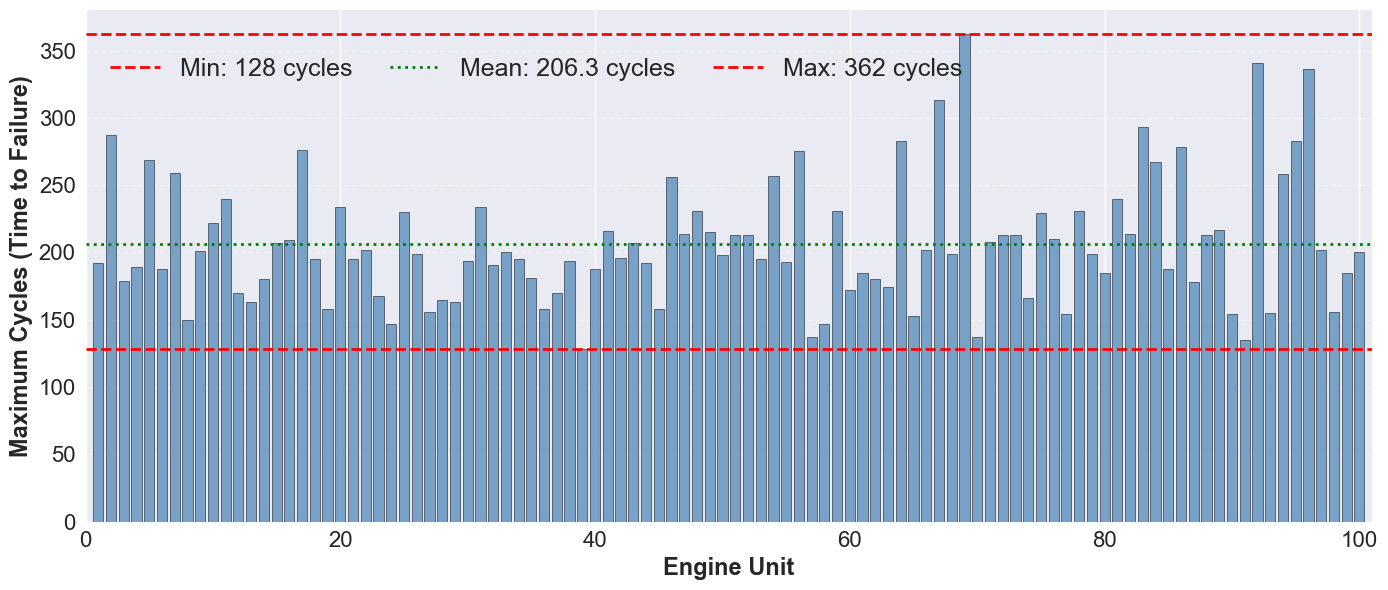


Generating sensor evolution plots over RUL...
Plotting sensors s1 to s12...


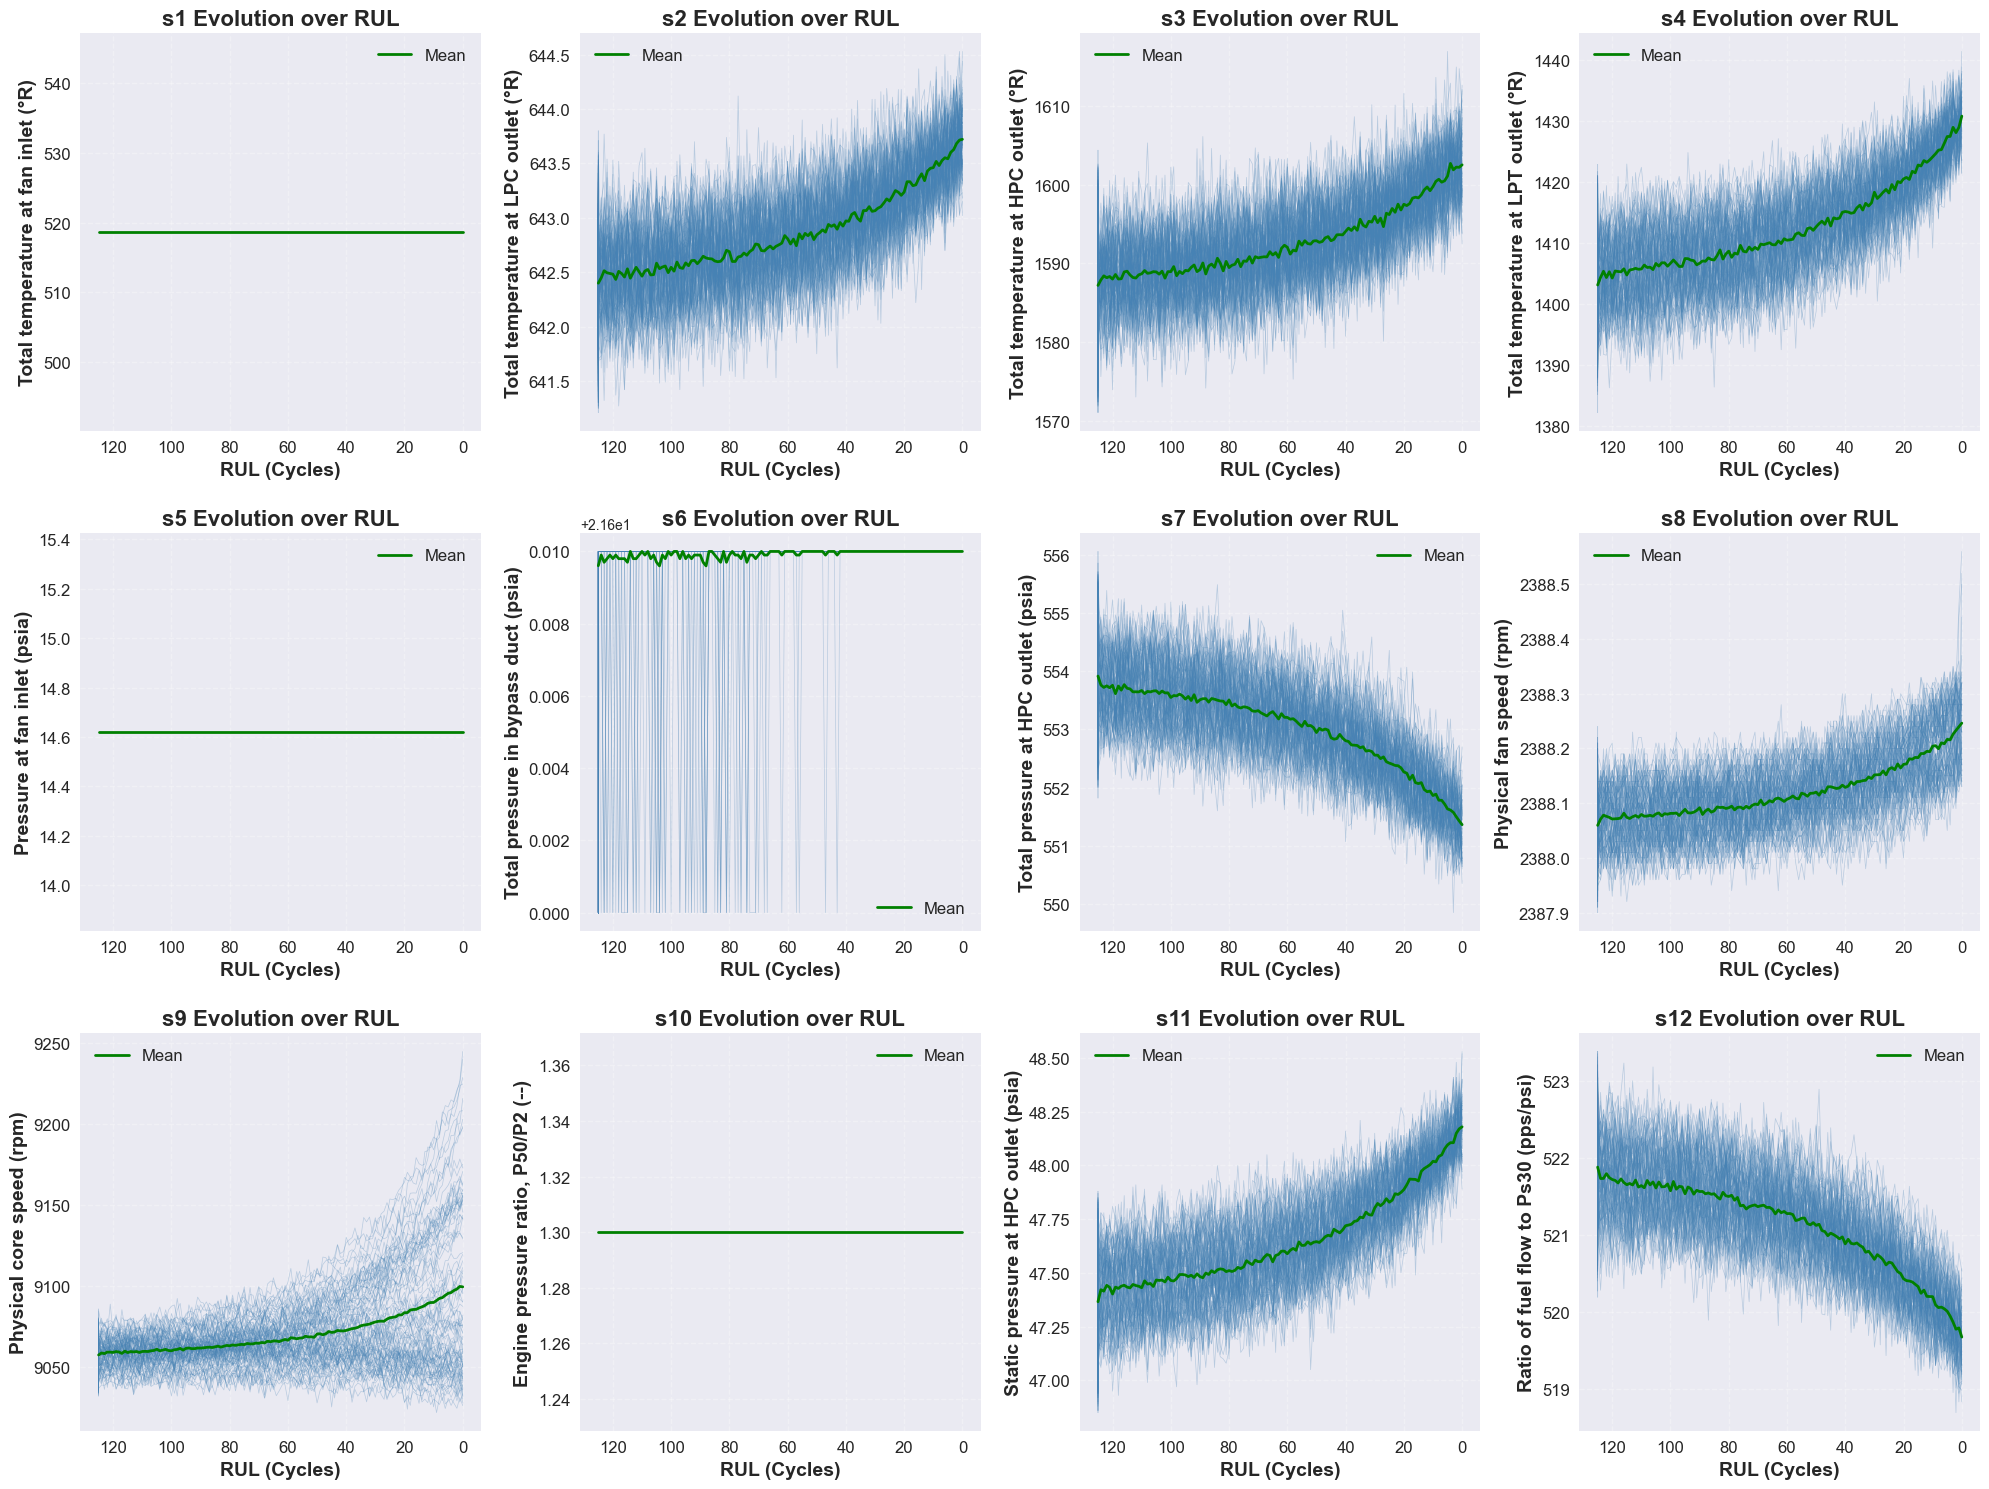

Plotting sensors s13 to s21...


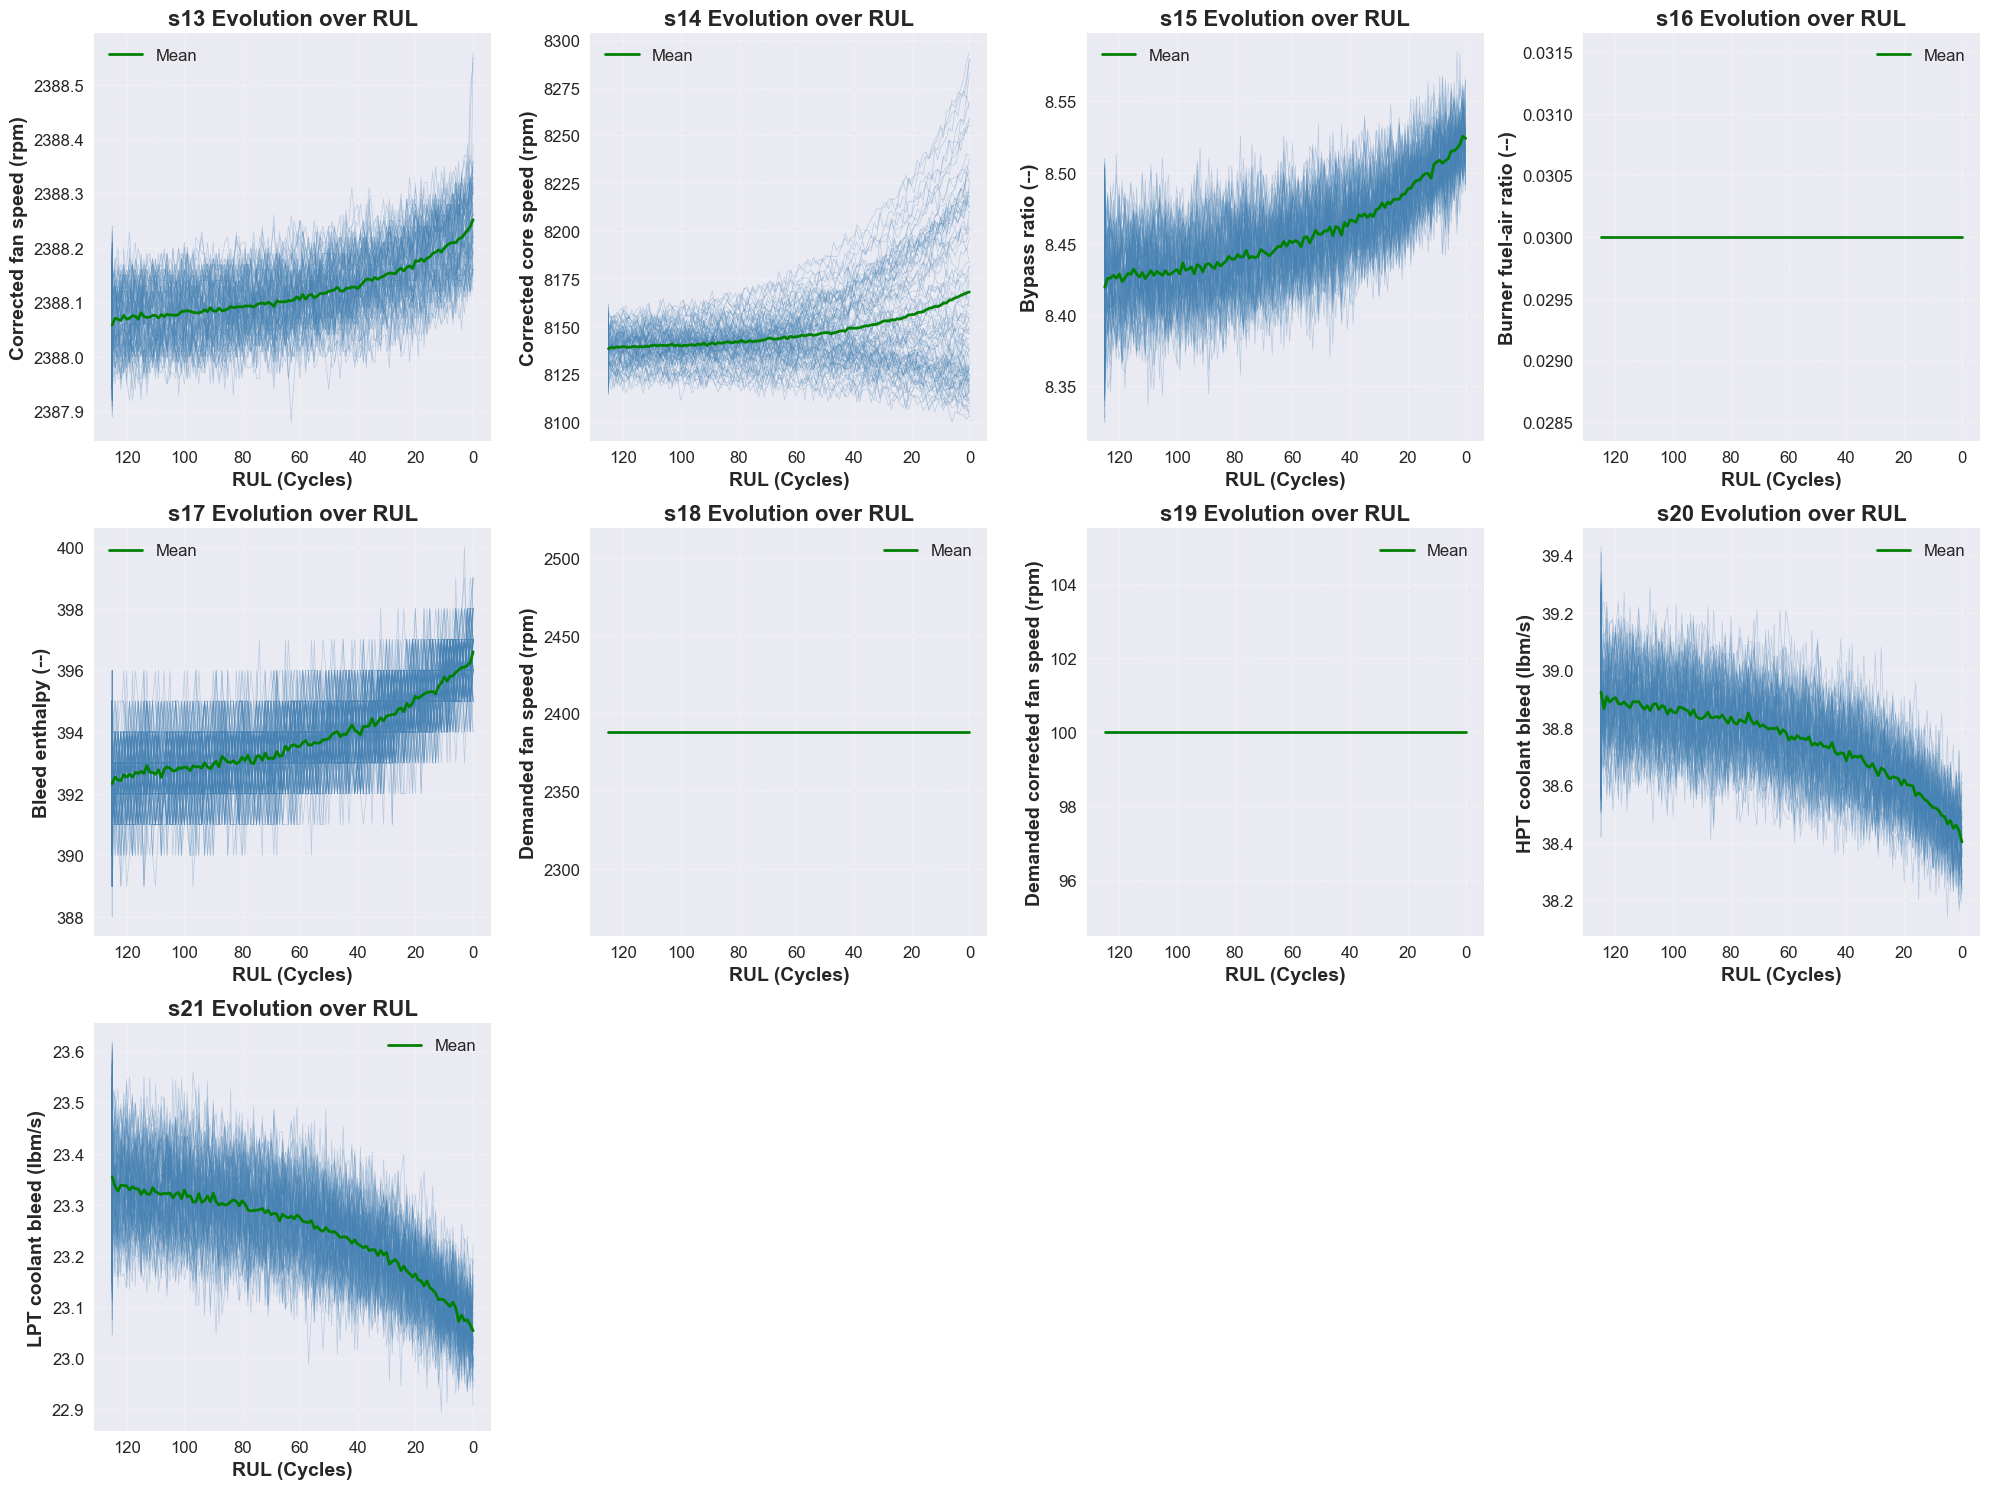

Sensor evolution plots complete

Generating representative sensor evolution plots...


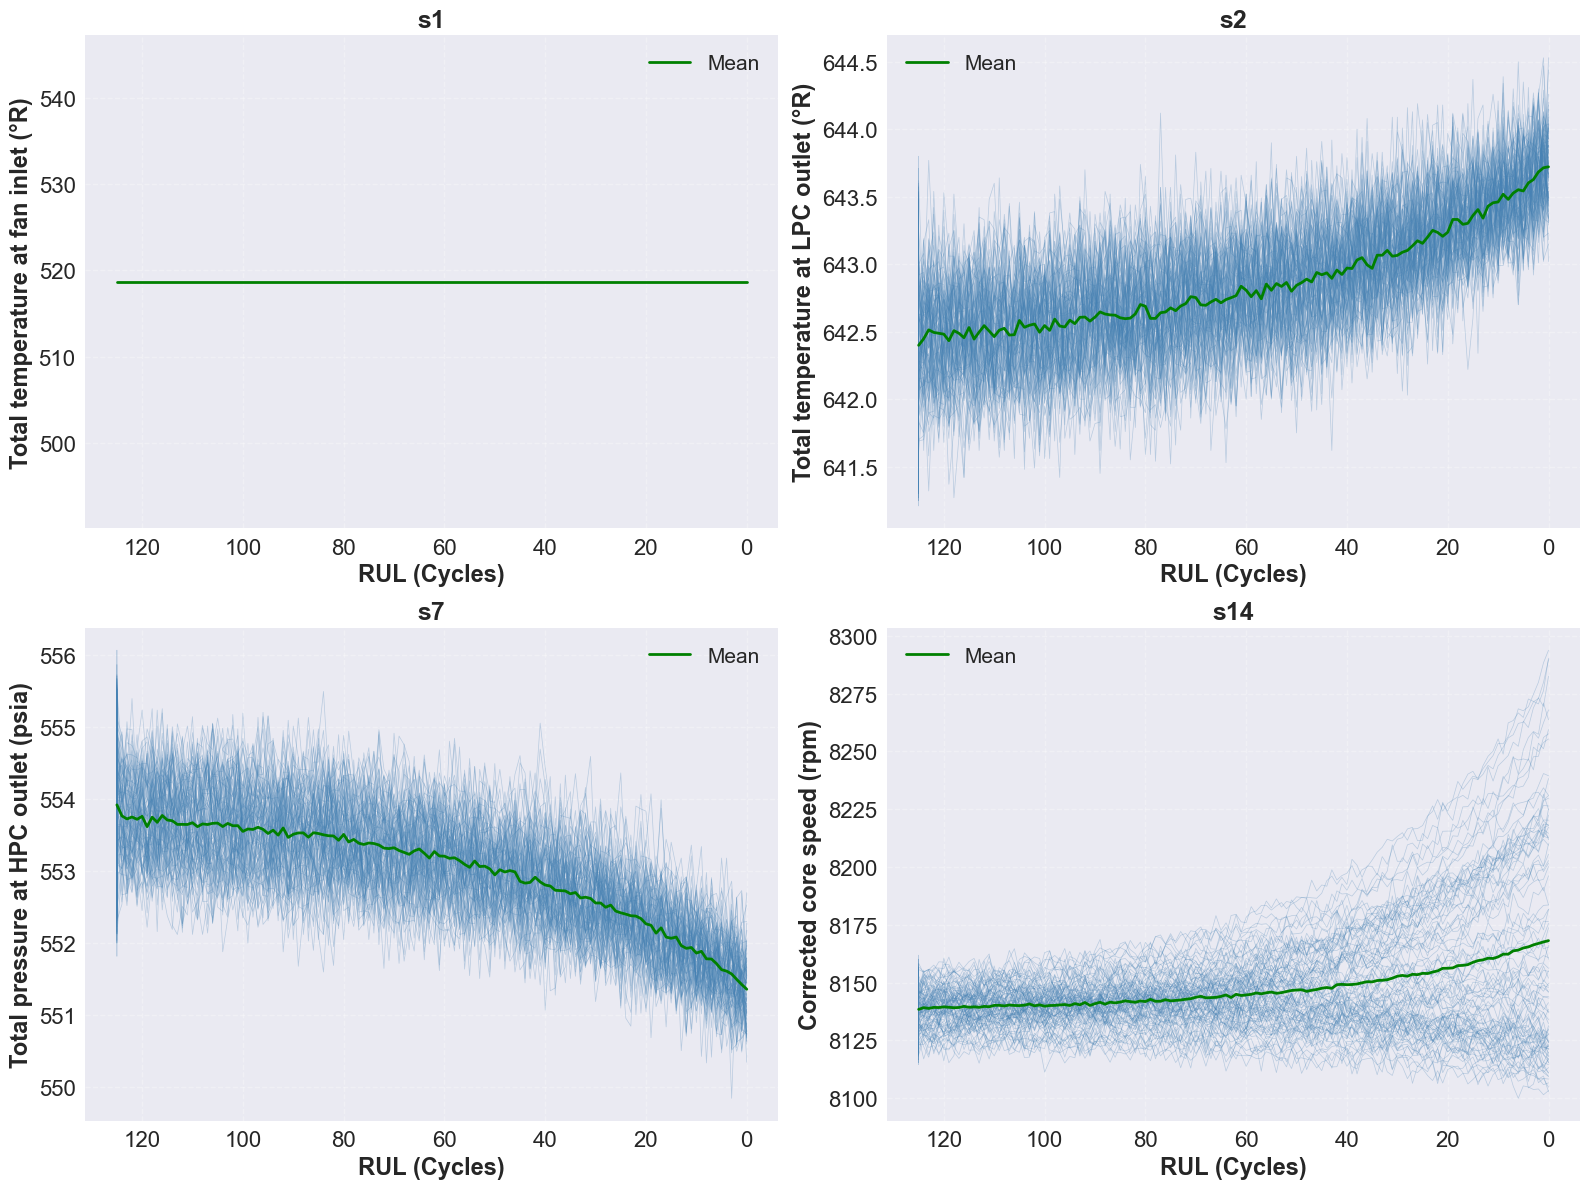

Representative sensor plots complete

Generating correlation matrix heatmap...


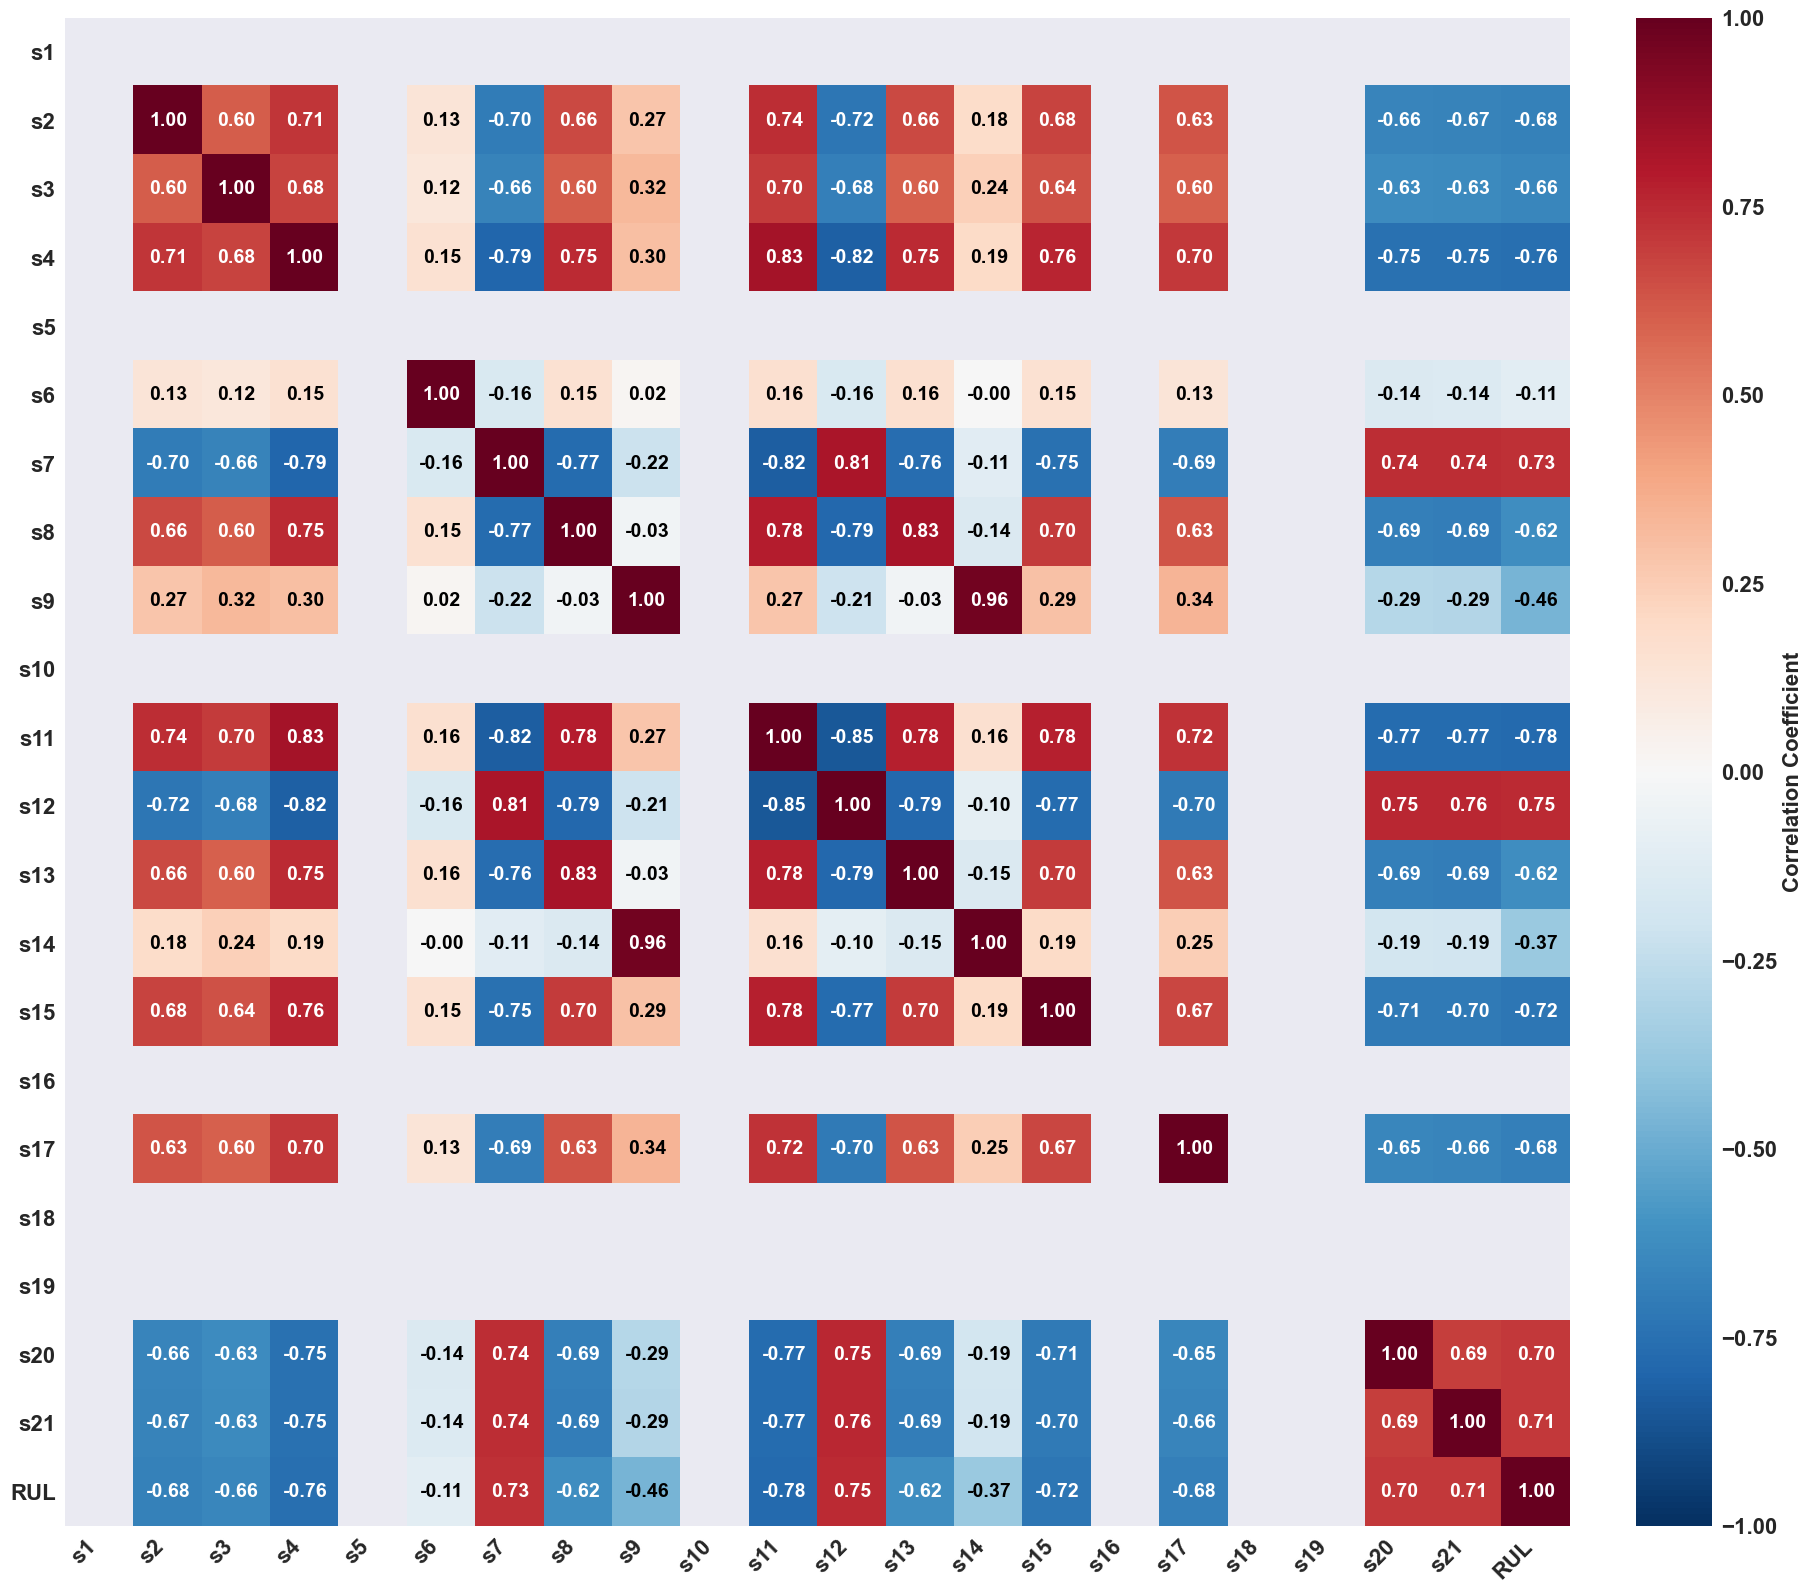

Correlation matrix heatmap complete


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(r"C:\Users\tiaan\Desktop\Submission_Tiaan_Mare_34584757")
from Utilities.config import RUL_CAP, WINDOW_SIZE

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Paths
base_raw_data_path = r"C:\Users\tiaan\Desktop\Submission_Tiaan_Mare_34584757\CodeBase_Experiments\1 CMAPSS ML Degredation Experiment\Data_CMAPSS\1_Raw_CMAPSS"

raw_train_path     = base_raw_data_path + r"\train_FD001.txt"
raw_test_path      = base_raw_data_path + r"\test_FD001.txt"
raw_test_RUL_path  = base_raw_data_path + r"\RUL_FD001.txt"

# Load data
raw_train_fd001 = pd.read_csv(raw_train_path, header = None, sep = " ")
raw_test_fd001 = pd.read_csv(raw_test_path, header = None, sep = " ")
raw_test_RUL_fd001 = pd.read_csv(raw_test_RUL_path, header = None, sep = " ")

# Clean data: drop NaN columns
na_cols = [26, 27]
raw_train_fd001 = raw_train_fd001.drop(columns=[col for col in na_cols if col in raw_train_fd001.columns])
raw_test_fd001 = raw_test_fd001.drop(columns=[col for col in na_cols if col in raw_test_fd001.columns])
raw_test_RUL_fd001 = raw_test_RUL_fd001.drop(columns=[col for col in [1] if col in raw_test_RUL_fd001.columns])

# Name columns
col_names = ['engine', 'cycle']
for i in range(3):
    col_names.append('os' + str(i+1))
for i in range(21):
    col_names.append('s' + str(i+1))

raw_train_fd001.columns = col_names
raw_test_fd001.columns = col_names
raw_test_RUL_fd001.columns = ["final_RUL"]

print("Data loaded and cleaned")
print(f"Training data shape: {raw_train_fd001.shape}")
print(f"\nFirst few rows:")
print(raw_train_fd001.head())

# Calculate RUL for training set
"""
For the training set, engines run all the way to failure, thus we can compute the 
RUL as the difference between the failure cycle and each earlier cycle.
"""
final_cycle_per_engine = raw_train_fd001.groupby('engine')['cycle'].max() #get final cycle for each engine
raw_train_fd001['final_cycle'] = raw_train_fd001['engine'].map(final_cycle_per_engine) #include the engine's last cycle (temp)
raw_train_fd001['RUL'] = raw_train_fd001['final_cycle'] - raw_train_fd001['cycle'] #calculate actual RUL
raw_train_fd001 = raw_train_fd001.drop(columns=['final_cycle']) #drop the feature that contains engine's last cycle

# Apply RUL cap
raw_train_fd001['RUL'] = raw_train_fd001['RUL'].clip(upper=RUL_CAP)

# Calculate RUL for test set
"""
For the test set, engines do not run to failure.  NASA did however provide the
RUL at the final recorded cycle of each engine. We can thus use that final RUL 
to reconstruct the full RUL curve backward so we can evaluate model performance 
on every test timestep.
"""
raw_test_RUL_fd001['engine'] = range(1, len(raw_test_RUL_fd001) + 1) # add engine numbers (identifiers) for each RUL value

final_cycle_per_engine = raw_test_fd001.groupby('engine')['cycle'].max() #get final cycle for each engine
raw_test_fd001 = raw_test_fd001.merge(raw_test_RUL_fd001, on='engine') #add test_RUL to the test set
raw_test_fd001['final_cycle'] = raw_test_fd001['engine'].map(final_cycle_per_engine) #each row will now include the engine's last cycle (temp)
raw_test_fd001['RUL'] = raw_test_fd001['final_RUL'] + (raw_test_fd001['final_cycle'] - raw_test_fd001['cycle']) #Calculate the actual RUL for each engine
raw_test_fd001 = raw_test_fd001.drop(columns=['final_RUL', 'final_cycle']) #drop temp columns

# Apply RUL cap
raw_test_fd001['RUL'] = raw_test_fd001['RUL'].clip(upper=RUL_CAP)

print("\nRUL calculated for training and test sets")

# Calculate maximum cycle for each engine (sorted by engine number to maintain order)
max_cycles_per_engine = raw_train_fd001.groupby('engine')['cycle'].max().sort_index()

print(f"\nMaximum cycles per engine statistics:")
print(f"Mean: {max_cycles_per_engine.mean():.2f}")
print(f"Median: {max_cycles_per_engine.median():.2f}")
print(f"Min: {max_cycles_per_engine.min()}")
print(f"Max: {max_cycles_per_engine.max()}")
print(f"Std: {max_cycles_per_engine.std():.2f}")

# Plot maximum cycles per engine
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(range(1, len(max_cycles_per_engine) + 1), max_cycles_per_engine.values, 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Engine Unit', fontsize=17, fontweight='bold')
ax.set_ylabel('Maximum Cycles (Time to Failure)', fontsize=17, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_xlim(0, len(max_cycles_per_engine) + 1)

# Set tick label font sizes
ax.tick_params(axis='both', labelsize=16)

# Calculate statistics
mean_cycles = max_cycles_per_engine.mean()
min_cycles = max_cycles_per_engine.min()
max_cycles = max_cycles_per_engine.max()

# Add lines in order: Min, Mean, Max (so mean appears in middle of legend)
# Add min line (red)
ax.axhline(y=min_cycles, color='red', linestyle='--', linewidth=2, 
            label=f'Min: {min_cycles:.0f} cycles')

# Add mean line (green dotted)
ax.axhline(y=mean_cycles, color='green', linestyle=':', linewidth=2, 
            label=f'Mean: {mean_cycles:.1f} cycles')

# Add max line (red)
ax.axhline(y=max_cycles, color='red', linestyle='--', linewidth=2, 
            label=f'Max: {max_cycles:.0f} cycles')

# Position legend horizontally, shifted to the left
ax.legend(fontsize=18, ncol=3, loc='upper center', bbox_to_anchor=(0.35, 0.95), 
          framealpha=0.9, columnspacing=1.5)

plt.tight_layout()
plt.show()

# Plot sensor evolution over RUL for all engines
print("\nGenerating sensor evolution plots over RUL...")

# Sensor name mapping
sensor_names = {
    's1': 'Total temperature at fan inlet (°R)',
    's2': 'Total temperature at LPC outlet (°R)',
    's3': 'Total temperature at HPC outlet (°R)',
    's4': 'Total temperature at LPT outlet (°R)',
    's5': 'Pressure at fan inlet (psia)',
    's6': 'Total pressure in bypass duct (psia)',
    's7': 'Total pressure at HPC outlet (psia)',
    's8': 'Physical fan speed (rpm)',
    's9': 'Physical core speed (rpm)',
    's10': 'Engine pressure ratio, P50/P2 (--)',
    's11': 'Static pressure at HPC outlet (psia)',
    's12': 'Ratio of fuel flow to Ps30 (pps/psi)',
    's13': 'Corrected fan speed (rpm)',
    's14': 'Corrected core speed (rpm)',
    's15': 'Bypass ratio (--)',
    's16': 'Burner fuel-air ratio (--)',
    's17': 'Bleed enthalpy (--)',
    's18': 'Demanded fan speed (rpm)',
    's19': 'Demanded corrected fan speed (rpm)',
    's20': 'HPT coolant bleed (lbm/s)',
    's21': 'LPT coolant bleed (lbm/s)'
}

# Get sensor column names
sensor_cols_all = [f's{i}' for i in range(1, 22)]

# Split sensors into two groups
sensor_cols_first = [f's{i}' for i in range(1, 13)]  # s1 to s12
sensor_cols_second = [f's{i}' for i in range(13, 22)]  # s13 to s21

# Function to plot sensor evolution
def plot_sensor_evolution(sensor_list, title_suffix=""):
    n_sensors = len(sensor_list)
    n_cols = 4
    n_rows = (n_sensors + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_sensors > 1 else [axes]
    
    for idx, sensor in enumerate(sensor_list):
        ax = axes[idx]
        
        # Plot each engine's sensor evolution over RUL
        for engine_id in sorted(raw_train_fd001['engine'].unique()):
            engine_data = raw_train_fd001[raw_train_fd001['engine'] == engine_id].sort_values('RUL')
            ax.plot(engine_data['RUL'], engine_data[sensor], alpha=0.3, linewidth=0.5, color='steelblue')
        
        # Calculate and plot mean trajectory
        mean_trajectory = raw_train_fd001.groupby('RUL')[sensor].mean().reset_index().sort_values('RUL')
        ax.plot(mean_trajectory['RUL'], mean_trajectory[sensor], 
                color='green', linewidth=2, label='Mean', zorder=10)
        
        ax.set_xlabel('RUL (Cycles)', fontsize=14, fontweight='bold')
        ax.set_ylabel(sensor_names[sensor], fontsize=14, fontweight='bold')
        ax.set_title(f'{sensor} Evolution over RUL', fontsize=16, fontweight='bold')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', labelsize=12)
        ax.invert_xaxis()  # RUL decreases as engine approaches failure
    
    # Hide unused subplots
    for idx in range(n_sensors, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot first group: s1 to s12
print("Plotting sensors s1 to s12...")
plot_sensor_evolution(sensor_cols_first)

# Plot second group: s13 to s21
print("Plotting sensors s13 to s21...")
plot_sensor_evolution(sensor_cols_second)

print("Sensor evolution plots complete")

# Plot representative sensors for main chapter
print("\nGenerating representative sensor evolution plots...")

# Selected representative sensors
representative_sensors = ['s1', 's2', 's7', 's14']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sensor in enumerate(representative_sensors):
    ax = axes[idx]
    
    # Plot each engine's sensor evolution over RUL
    for engine_id in sorted(raw_train_fd001['engine'].unique()):
        engine_data = raw_train_fd001[raw_train_fd001['engine'] == engine_id].sort_values('RUL')
        ax.plot(engine_data['RUL'], engine_data[sensor], alpha=0.3, linewidth=0.5, color='steelblue')
    
    # Calculate and plot mean trajectory
    mean_trajectory = raw_train_fd001.groupby('RUL')[sensor].mean().reset_index().sort_values('RUL')
    ax.plot(mean_trajectory['RUL'], mean_trajectory[sensor], 
            color='green', linewidth=2, label='Mean', zorder=10)
    
    ax.set_xlabel('RUL (Cycles)', fontsize=17, fontweight='bold')
    ax.set_ylabel(sensor_names[sensor], fontsize=17, fontweight='bold')
    ax.set_title(f'{sensor}', fontsize=18, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=16)
    ax.invert_xaxis()  # RUL decreases as engine approaches failure

plt.tight_layout()
plt.show()

print("Representative sensor plots complete")

#  Correlation matrix heatmap: all sensors and RUL
print("\nGenerating correlation matrix heatmap...")

# Get all sensor columns
sensor_cols = [f's{i}' for i in range(1, 22)]
all_features = sensor_cols + ['RUL']

# Calculate correlation matrix
correlation_matrix = raw_train_fd001[all_features].corr()

# Create heatmap using seaborn for better visualization
fig, ax = plt.subplots(figsize=(18, 16))

# Create heatmap
im = ax.imshow(correlation_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
tick_labels = correlation_matrix.columns.tolist()
ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels, fontsize=16, fontweight='bold', rotation=45, ha='right')
ax.set_yticklabels(tick_labels, fontsize=16, fontweight='bold')

# Add text annotations with correlation values for all cells
for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        corr_value = correlation_matrix.iloc[i, j]
        # Skip NaN values
        if pd.notna(corr_value):
            # White text if |correlation| >= 0.5, black otherwise
            text_color = 'white' if abs(corr_value) >= 0.5 else 'black'
            ax.text(j, i, f'{corr_value:.2f}', ha='center', va='center', 
                    fontsize=14, fontweight='bold', color=text_color)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=16, fontweight='bold')

ax.grid(False)

plt.tight_layout()

# Set colorbar tick label size after tight_layout (to ensure it sticks)
cbar.ax.tick_params(labelsize=16)
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(16)
    label.set_fontweight('bold')

plt.show()

print("Correlation matrix heatmap complete")


Data loaded and cleaned
Training data shape: (20631, 26)

First few rows:
   engine  cycle     os1     os2    os3      s1      s2       s3       s4  \
0       1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1       1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2       1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3       1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4       1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20    

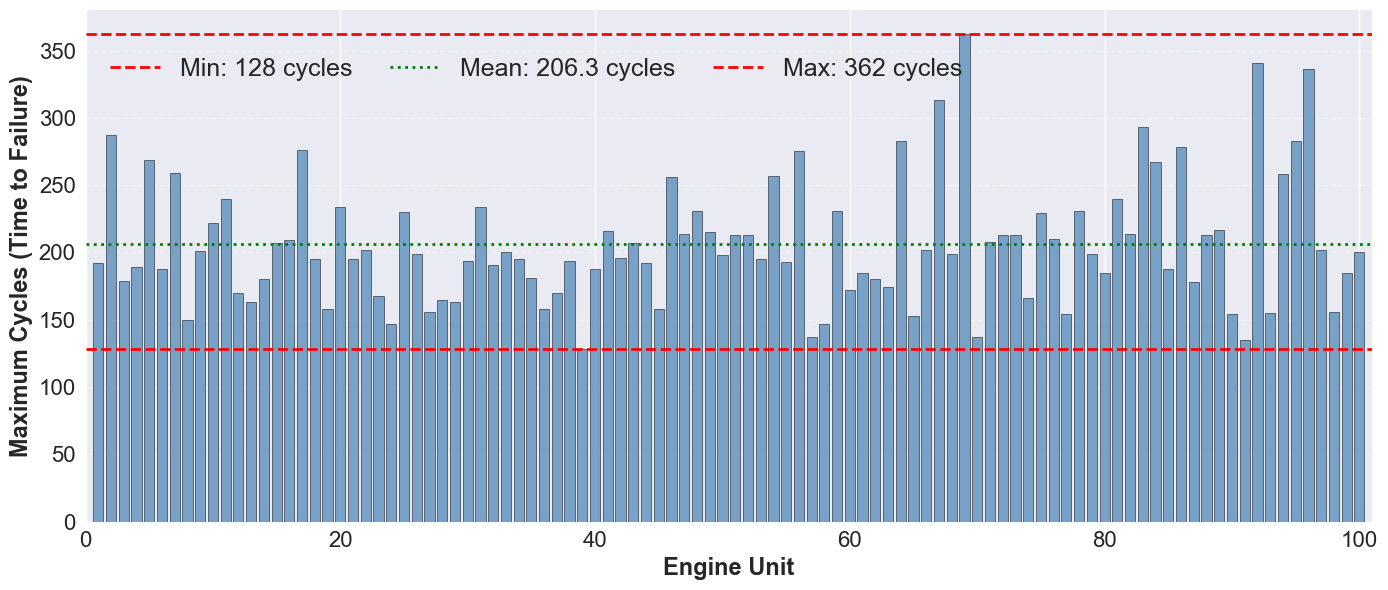


Generating sensor evolution plots over RUL...
Plotting sensors s1 to s12...


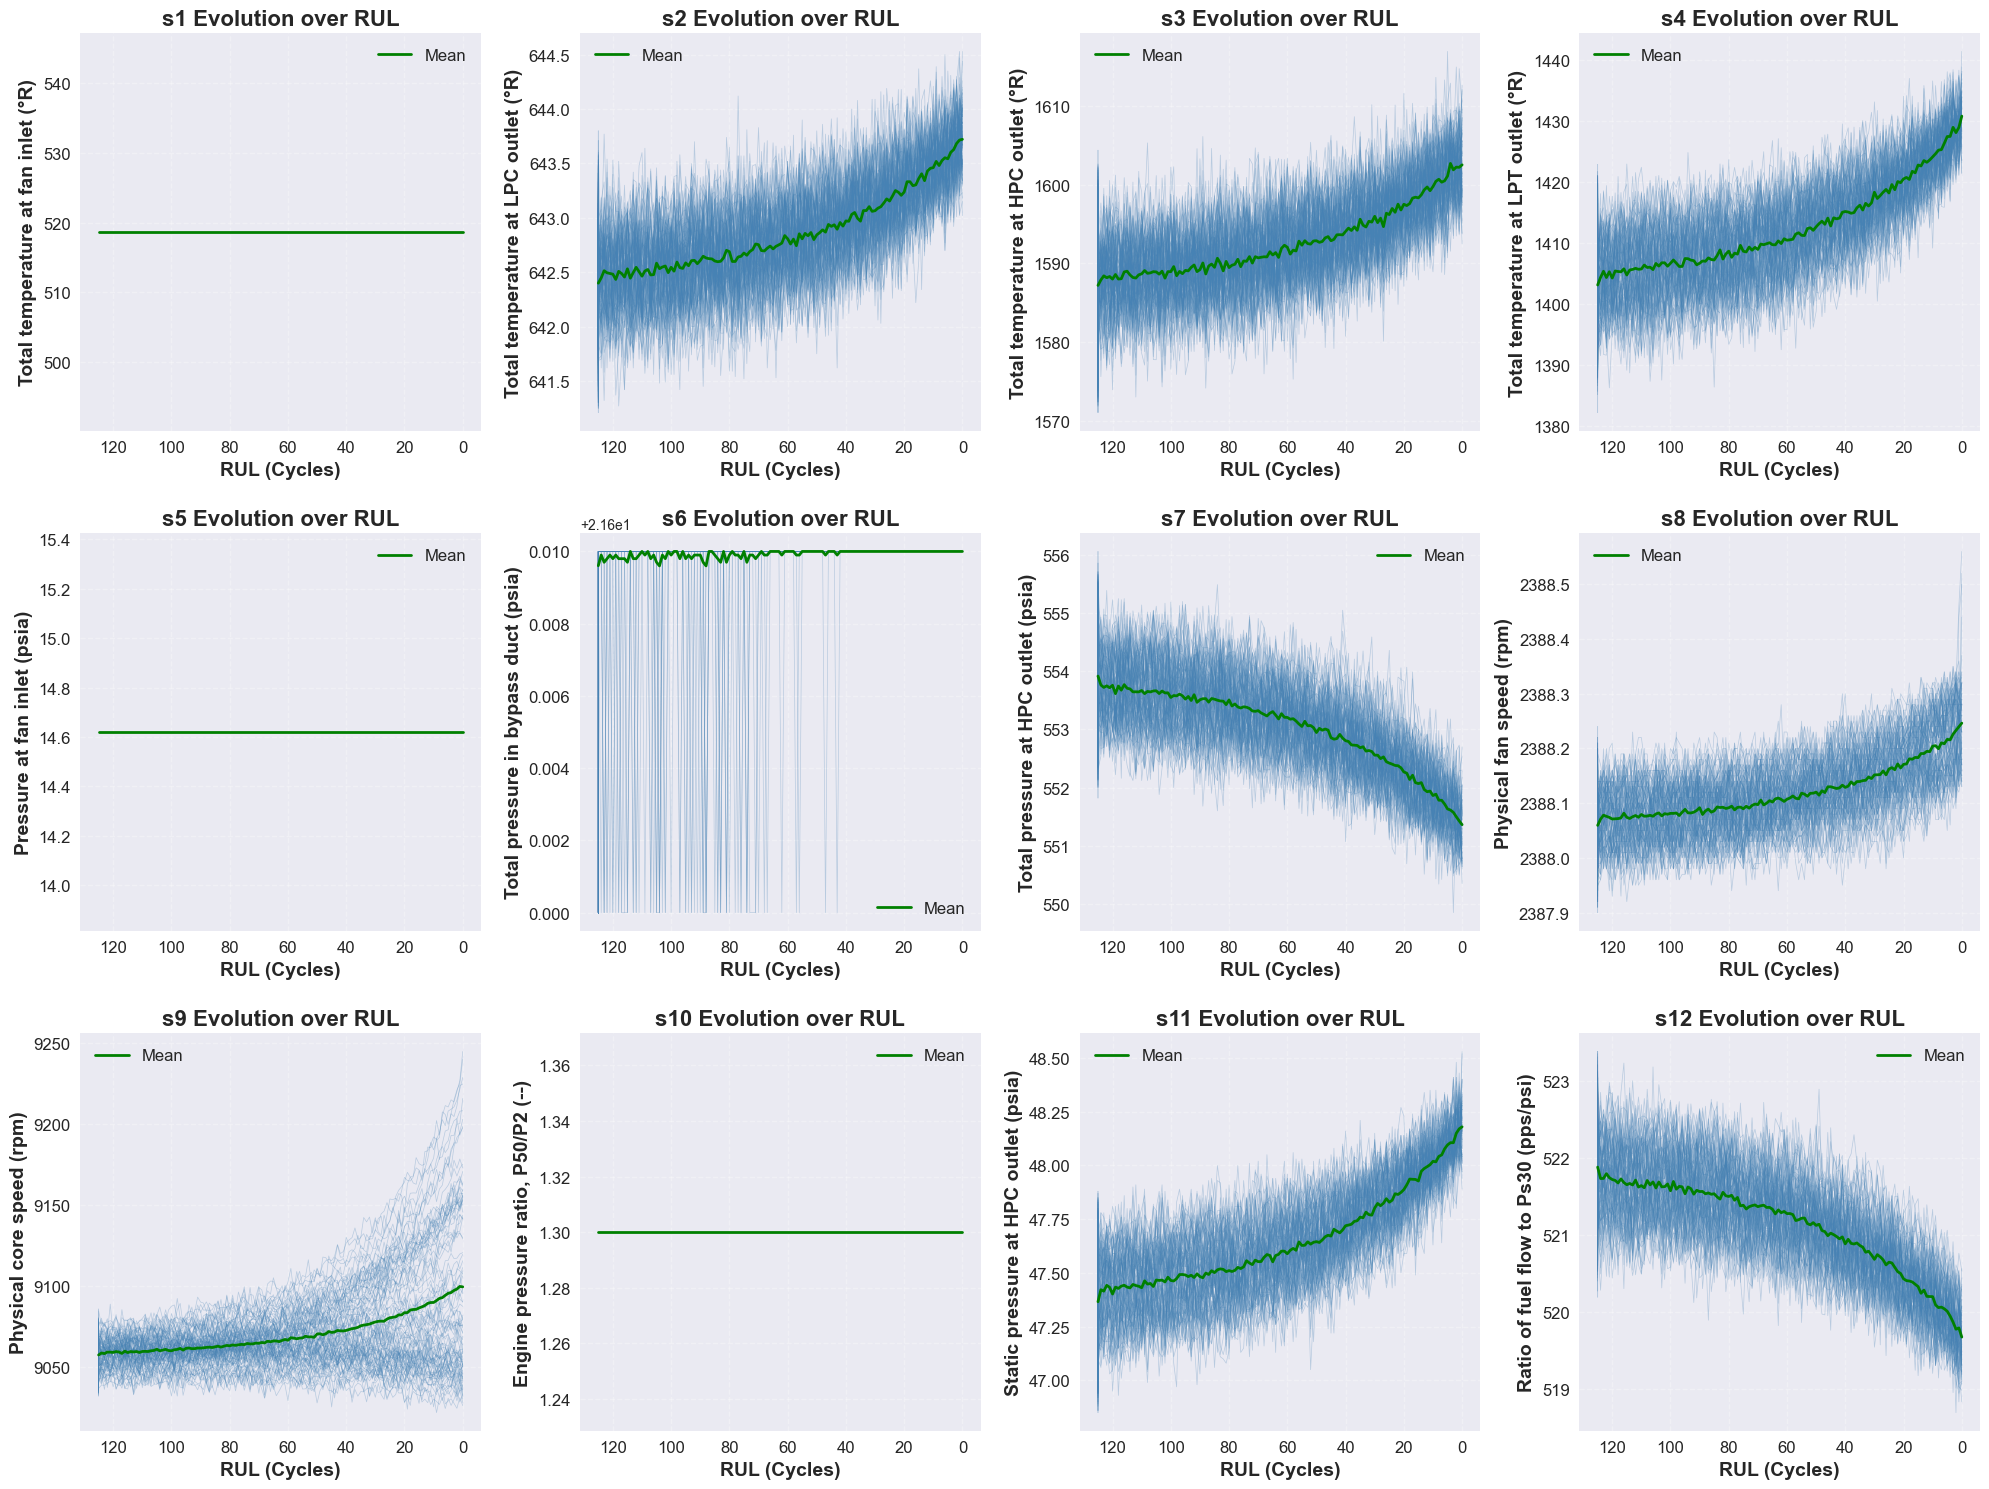

Plotting sensors s13 to s21...


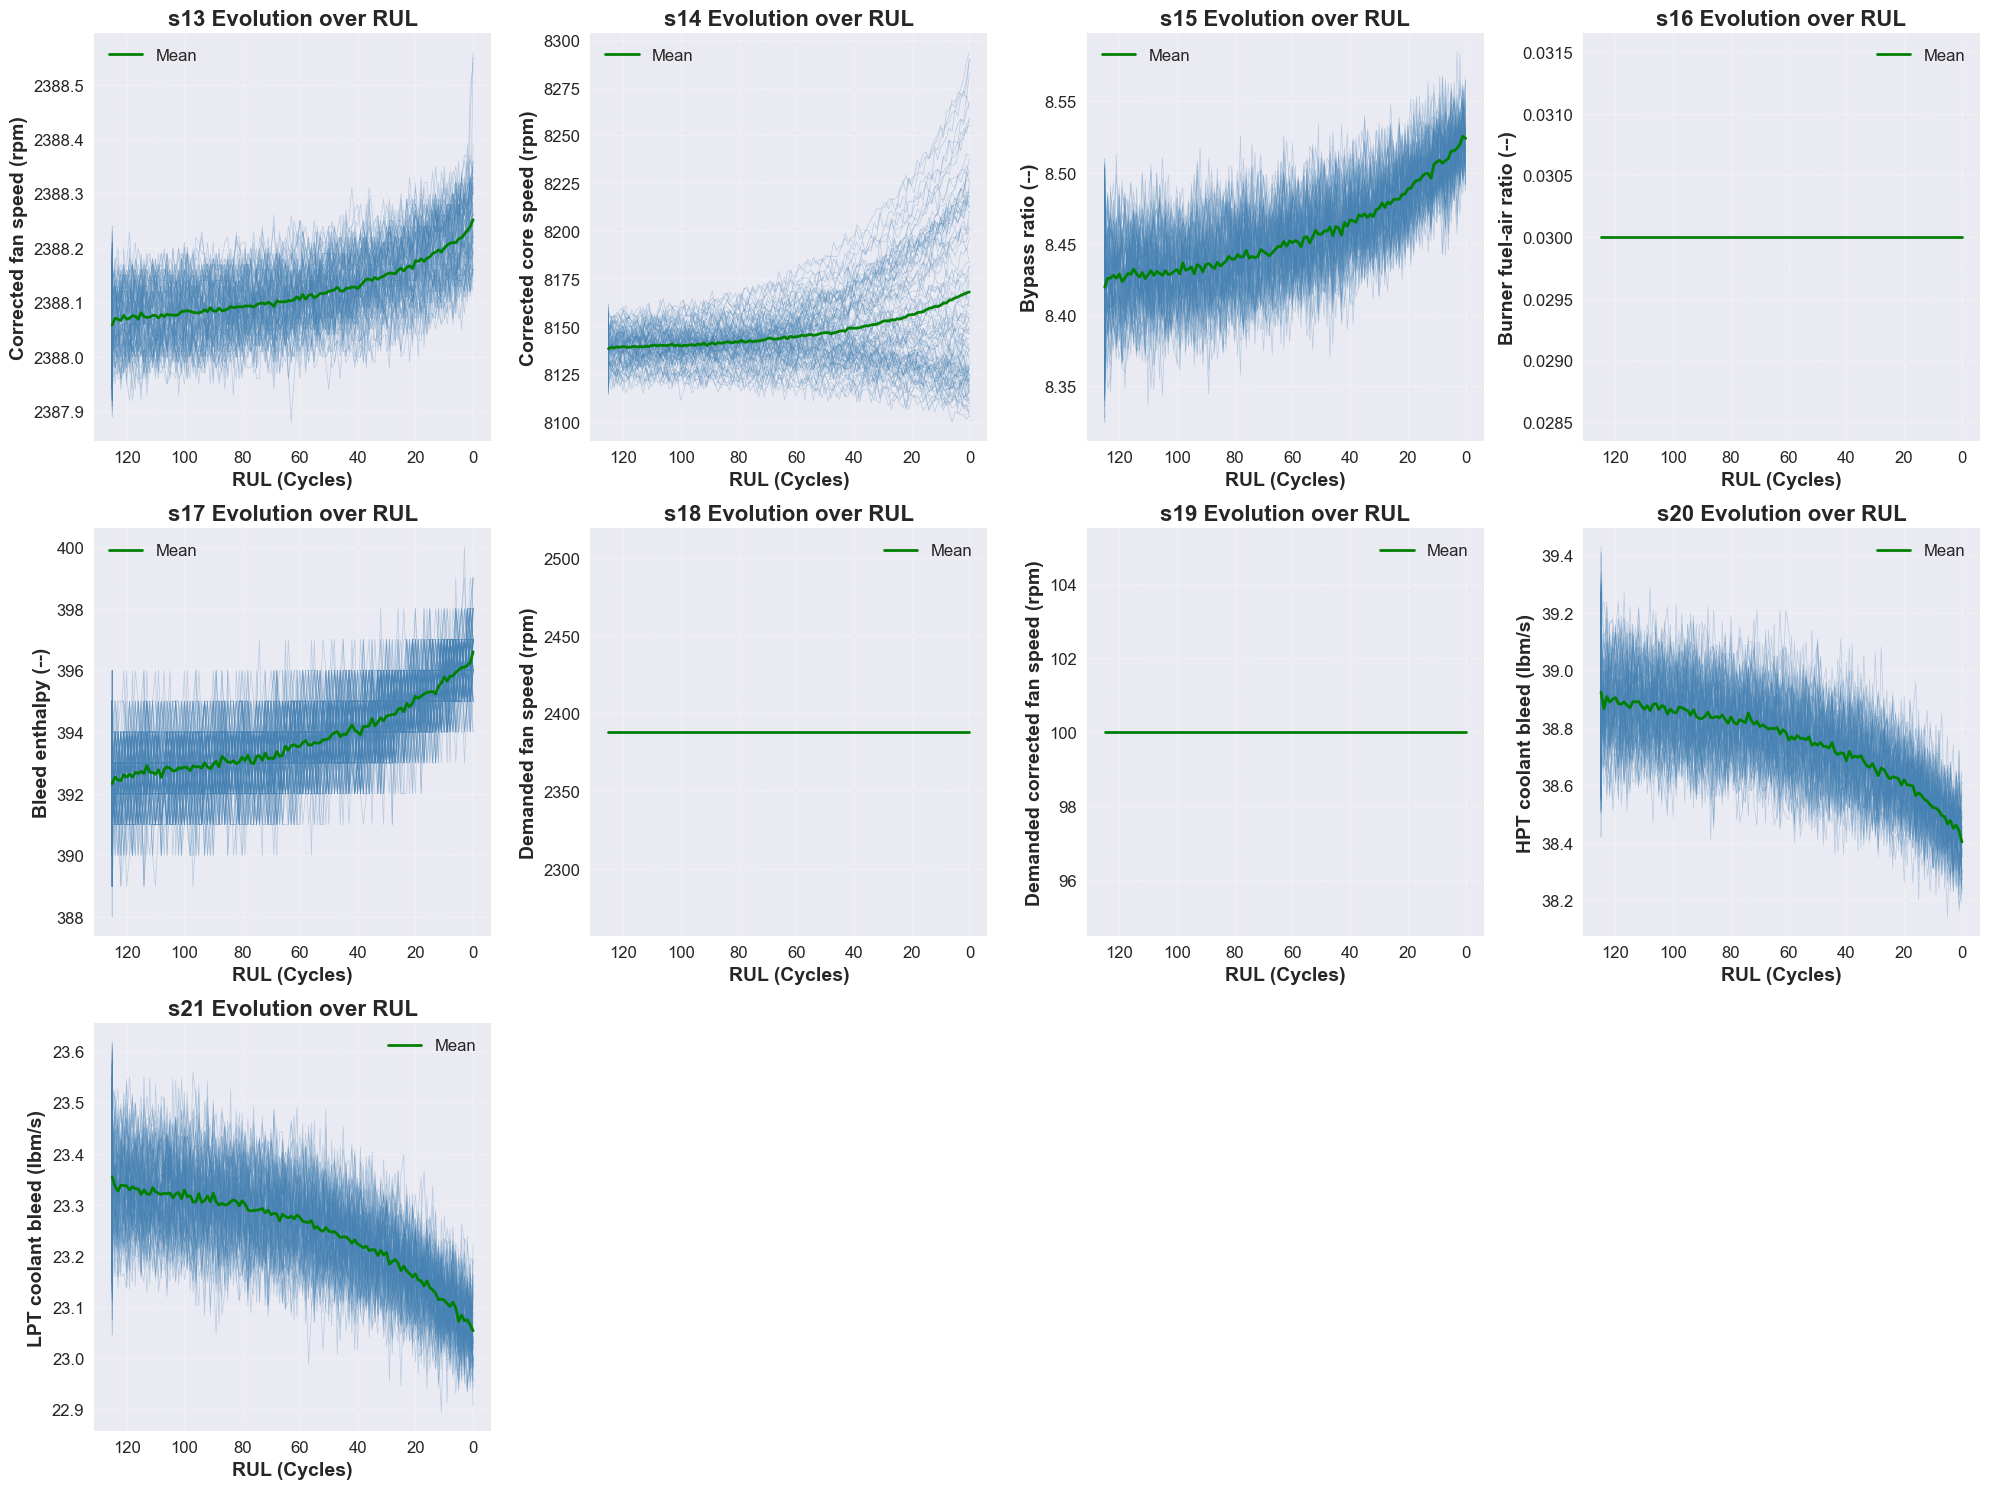

Sensor evolution plots complete

Generating representative sensor evolution plots...


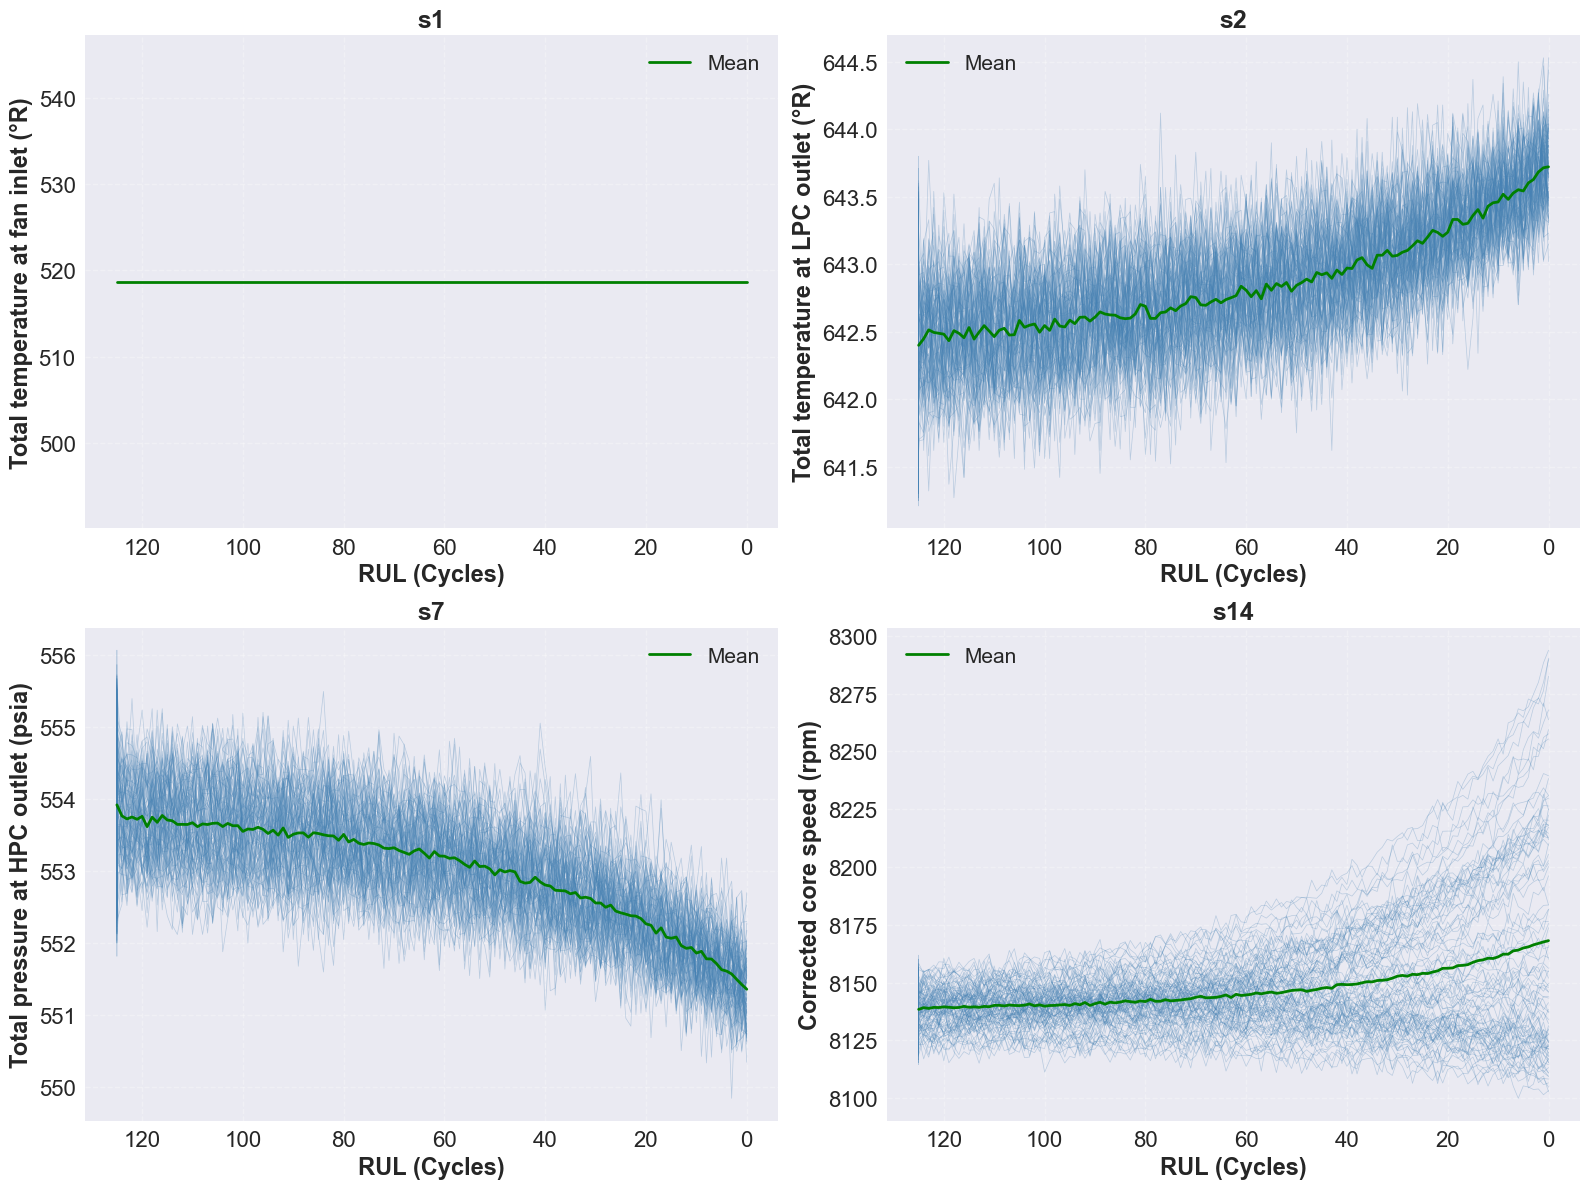

Representative sensor plots complete

Generating correlation matrix heatmap...

Sensor Correlations with RUL (sorted by absolute value)
s11 : -0.7752
s4  : -0.7572
s12 :  0.7489
s7  :  0.7330
s15 : -0.7209
s21 :  0.7073
s20 :  0.7046
s17 : -0.6808
s2  : -0.6785
s3  : -0.6550
s8  : -0.6246
s13 : -0.6240
s9  : -0.4622
s14 : -0.3698
s6  : -0.1083
s1  :     nan
s5  :     nan
s10 :     nan
s16 :     nan
s18 :     nan
s19 :     nan



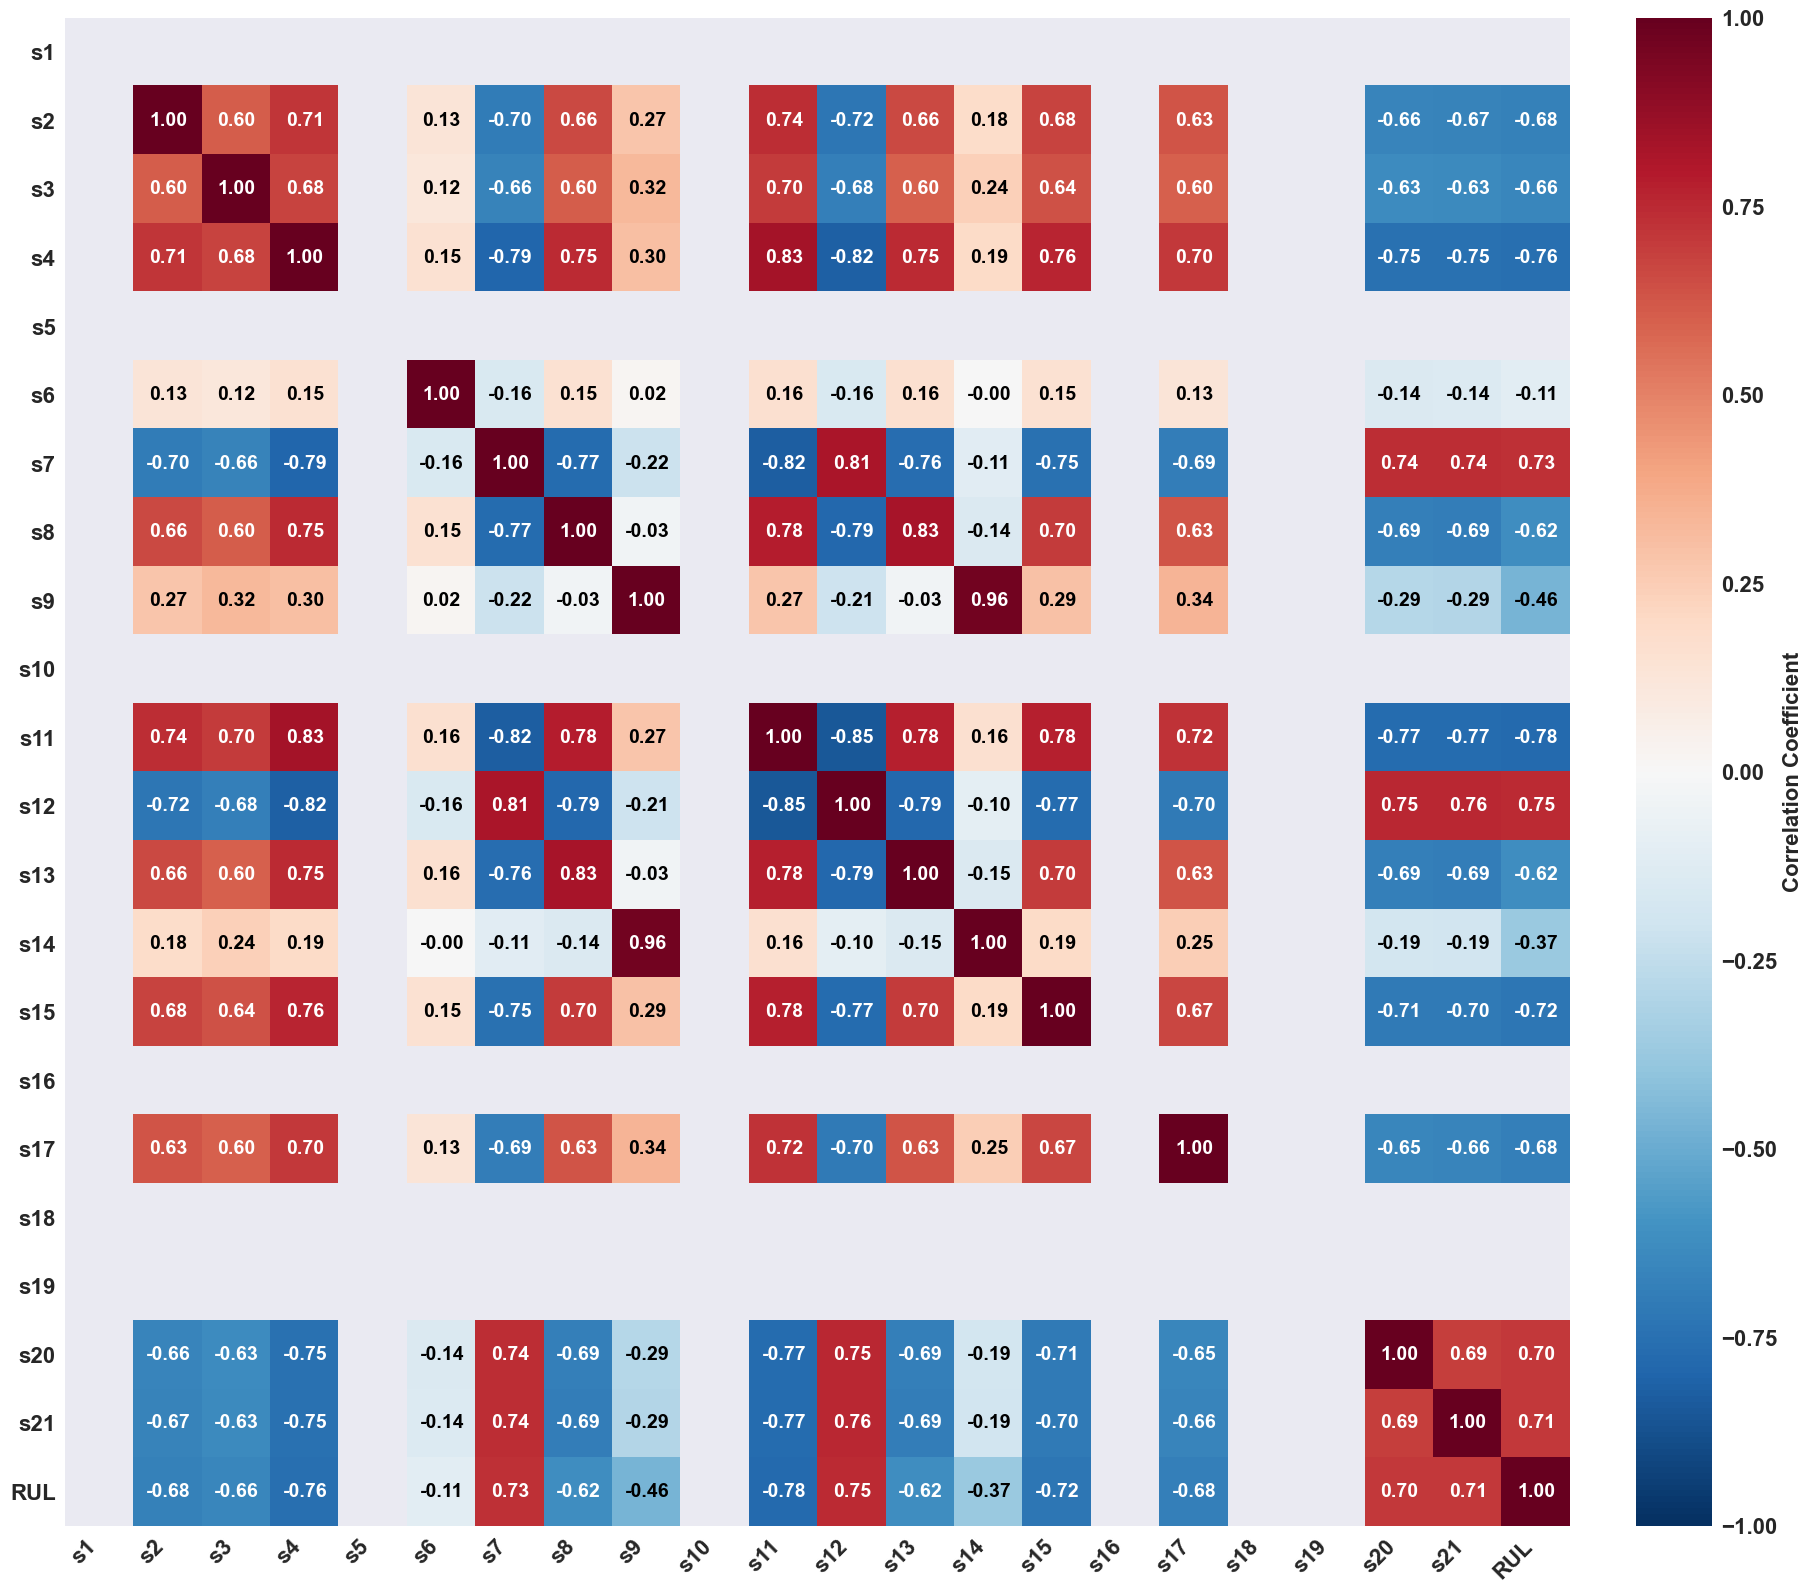

Correlation matrix heatmap complete


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(r"C:\Users\tiaan\Desktop\Submission_Tiaan_Mare_34584757")
from Utilities.config import RUL_CAP, WINDOW_SIZE

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Paths
base_raw_data_path = r"C:\Users\tiaan\Desktop\Submission_Tiaan_Mare_34584757\CodeBase_Experiments\1 CMAPSS ML Degredation Experiment\Data_CMAPSS\1_Raw_CMAPSS"

raw_train_path     = base_raw_data_path + r"\train_FD001.txt"
raw_test_path      = base_raw_data_path + r"\test_FD001.txt"
raw_test_RUL_path  = base_raw_data_path + r"\RUL_FD001.txt"

# Load data
raw_train_fd001 = pd.read_csv(raw_train_path, header = None, sep = " ")
raw_test_fd001 = pd.read_csv(raw_test_path, header = None, sep = " ")
raw_test_RUL_fd001 = pd.read_csv(raw_test_RUL_path, header = None, sep = " ")

# Clean data: drop NaN columns
na_cols = [26, 27]
raw_train_fd001 = raw_train_fd001.drop(columns=[col for col in na_cols if col in raw_train_fd001.columns])
raw_test_fd001 = raw_test_fd001.drop(columns=[col for col in na_cols if col in raw_test_fd001.columns])
raw_test_RUL_fd001 = raw_test_RUL_fd001.drop(columns=[col for col in [1] if col in raw_test_RUL_fd001.columns])

# Name columns
col_names = ['engine', 'cycle']
for i in range(3):
    col_names.append('os' + str(i+1))
for i in range(21):
    col_names.append('s' + str(i+1))

raw_train_fd001.columns = col_names
raw_test_fd001.columns = col_names
raw_test_RUL_fd001.columns = ["final_RUL"]

print("Data loaded and cleaned")
print(f"Training data shape: {raw_train_fd001.shape}")
print(f"\nFirst few rows:")
print(raw_train_fd001.head())

# Calculate RUL for training set
"""
For the training set, engines run all the way to failure, thus we can compute the 
RUL as the difference between the failure cycle and each earlier cycle.
"""
final_cycle_per_engine = raw_train_fd001.groupby('engine')['cycle'].max() #get final cycle for each engine
raw_train_fd001['final_cycle'] = raw_train_fd001['engine'].map(final_cycle_per_engine) #include the engine's last cycle (temp)
raw_train_fd001['RUL'] = raw_train_fd001['final_cycle'] - raw_train_fd001['cycle'] #calculate actual RUL
raw_train_fd001 = raw_train_fd001.drop(columns=['final_cycle']) #drop the feature that contains engine's last cycle

# Apply RUL cap
raw_train_fd001['RUL'] = raw_train_fd001['RUL'].clip(upper=RUL_CAP)

# Calculate RUL for test set
"""
For the test set, engines do not run to failure.  NASA did however provide the
RUL at the final recorded cycle of each engine. We can thus use that final RUL 
to reconstruct the full RUL curve backward so we can evaluate model performance 
on every test timestep.
"""
raw_test_RUL_fd001['engine'] = range(1, len(raw_test_RUL_fd001) + 1) # add engine numbers (identifiers) for each RUL value

final_cycle_per_engine = raw_test_fd001.groupby('engine')['cycle'].max() #get final cycle for each engine
raw_test_fd001 = raw_test_fd001.merge(raw_test_RUL_fd001, on='engine') #add test_RUL to the test set
raw_test_fd001['final_cycle'] = raw_test_fd001['engine'].map(final_cycle_per_engine) #each row will now include the engine's last cycle (temp)
raw_test_fd001['RUL'] = raw_test_fd001['final_RUL'] + (raw_test_fd001['final_cycle'] - raw_test_fd001['cycle']) #Calculate the actual RUL for each engine
raw_test_fd001 = raw_test_fd001.drop(columns=['final_RUL', 'final_cycle']) #drop temp columns

# Apply RUL cap
raw_test_fd001['RUL'] = raw_test_fd001['RUL'].clip(upper=RUL_CAP)

print("\nRUL calculated for training and test sets")

# Calculate maximum cycle for each engine (sorted by engine number to maintain order)
max_cycles_per_engine = raw_train_fd001.groupby('engine')['cycle'].max().sort_index()

print(f"\nMaximum cycles per engine statistics:")
print(f"Mean: {max_cycles_per_engine.mean():.2f}")
print(f"Median: {max_cycles_per_engine.median():.2f}")
print(f"Min: {max_cycles_per_engine.min()}")
print(f"Max: {max_cycles_per_engine.max()}")
print(f"Std: {max_cycles_per_engine.std():.2f}")

# Plot maximum cycles per engine
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(range(1, len(max_cycles_per_engine) + 1), max_cycles_per_engine.values, 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Engine Unit', fontsize=17, fontweight='bold')
ax.set_ylabel('Maximum Cycles (Time to Failure)', fontsize=17, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_xlim(0, len(max_cycles_per_engine) + 1)

# Set tick label font sizes
ax.tick_params(axis='both', labelsize=16)

# Calculate statistics
mean_cycles = max_cycles_per_engine.mean()
min_cycles = max_cycles_per_engine.min()
max_cycles = max_cycles_per_engine.max()

# Add lines in order: Min, Mean, Max (so mean appears in middle of legend)
# Add min line (red)
ax.axhline(y=min_cycles, color='red', linestyle='--', linewidth=2, 
            label=f'Min: {min_cycles:.0f} cycles')

# Add mean line (green dotted)
ax.axhline(y=mean_cycles, color='green', linestyle=':', linewidth=2, 
            label=f'Mean: {mean_cycles:.1f} cycles')

# Add max line (red)
ax.axhline(y=max_cycles, color='red', linestyle='--', linewidth=2, 
            label=f'Max: {max_cycles:.0f} cycles')

# Position legend horizontally, shifted to the left
ax.legend(fontsize=18, ncol=3, loc='upper center', bbox_to_anchor=(0.35, 0.95), 
          framealpha=0.9, columnspacing=1.5)

plt.tight_layout()
plt.show()

# Plot sensor evolution over RUL for all engines
print("\nGenerating sensor evolution plots over RUL...")

# Sensor name mapping
sensor_names = {
    's1': 'Total temperature at fan inlet (°R)',
    's2': 'Total temperature at LPC outlet (°R)',
    's3': 'Total temperature at HPC outlet (°R)',
    's4': 'Total temperature at LPT outlet (°R)',
    's5': 'Pressure at fan inlet (psia)',
    's6': 'Total pressure in bypass duct (psia)',
    's7': 'Total pressure at HPC outlet (psia)',
    's8': 'Physical fan speed (rpm)',
    's9': 'Physical core speed (rpm)',
    's10': 'Engine pressure ratio, P50/P2 (--)',
    's11': 'Static pressure at HPC outlet (psia)',
    's12': 'Ratio of fuel flow to Ps30 (pps/psi)',
    's13': 'Corrected fan speed (rpm)',
    's14': 'Corrected core speed (rpm)',
    's15': 'Bypass ratio (--)',
    's16': 'Burner fuel-air ratio (--)',
    's17': 'Bleed enthalpy (--)',
    's18': 'Demanded fan speed (rpm)',
    's19': 'Demanded corrected fan speed (rpm)',
    's20': 'HPT coolant bleed (lbm/s)',
    's21': 'LPT coolant bleed (lbm/s)'
}

# Get sensor column names
sensor_cols_all = [f's{i}' for i in range(1, 22)]

# Split sensors into two groups
sensor_cols_first = [f's{i}' for i in range(1, 13)]  # s1 to s12
sensor_cols_second = [f's{i}' for i in range(13, 22)]  # s13 to s21

# Function to plot sensor evolution
def plot_sensor_evolution(sensor_list, title_suffix=""):
    n_sensors = len(sensor_list)
    n_cols = 4
    n_rows = (n_sensors + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_sensors > 1 else [axes]
    
    for idx, sensor in enumerate(sensor_list):
        ax = axes[idx]
        
        # Plot each engine's sensor evolution over RUL
        for engine_id in sorted(raw_train_fd001['engine'].unique()):
            engine_data = raw_train_fd001[raw_train_fd001['engine'] == engine_id].sort_values('RUL')
            ax.plot(engine_data['RUL'], engine_data[sensor], alpha=0.3, linewidth=0.5, color='steelblue')
        
        # Calculate and plot mean trajectory
        mean_trajectory = raw_train_fd001.groupby('RUL')[sensor].mean().reset_index().sort_values('RUL')
        ax.plot(mean_trajectory['RUL'], mean_trajectory[sensor], 
                color='green', linewidth=2, label='Mean', zorder=10)
        
        ax.set_xlabel('RUL (Cycles)', fontsize=14, fontweight='bold')
        ax.set_ylabel(sensor_names[sensor], fontsize=14, fontweight='bold')
        ax.set_title(f'{sensor} Evolution over RUL', fontsize=16, fontweight='bold')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', labelsize=12)
        ax.invert_xaxis()  # RUL decreases as engine approaches failure
    
    # Hide unused subplots
    for idx in range(n_sensors, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot first group: s1 to s12
print("Plotting sensors s1 to s12...")
plot_sensor_evolution(sensor_cols_first)

# Plot second group: s13 to s21
print("Plotting sensors s13 to s21...")
plot_sensor_evolution(sensor_cols_second)

print("Sensor evolution plots complete")

# Plot representative sensors for main chapter
print("\nGenerating representative sensor evolution plots...")

# Selected representative sensors
representative_sensors = ['s1', 's2', 's7', 's14']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sensor in enumerate(representative_sensors):
    ax = axes[idx]
    
    # Plot each engine's sensor evolution over RUL
    for engine_id in sorted(raw_train_fd001['engine'].unique()):
        engine_data = raw_train_fd001[raw_train_fd001['engine'] == engine_id].sort_values('RUL')
        ax.plot(engine_data['RUL'], engine_data[sensor], alpha=0.3, linewidth=0.5, color='steelblue')
    
    # Calculate and plot mean trajectory
    mean_trajectory = raw_train_fd001.groupby('RUL')[sensor].mean().reset_index().sort_values('RUL')
    ax.plot(mean_trajectory['RUL'], mean_trajectory[sensor], 
            color='green', linewidth=2, label='Mean', zorder=10)
    
    ax.set_xlabel('RUL (Cycles)', fontsize=17, fontweight='bold')
    ax.set_ylabel(sensor_names[sensor], fontsize=17, fontweight='bold')
    ax.set_title(f'{sensor}', fontsize=18, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=16)
    ax.invert_xaxis()  # RUL decreases as engine approaches failure

plt.tight_layout()
plt.show()

print("Representative sensor plots complete")

#  Correlation matrix heatmap: all sensors and RUL
print("\nGenerating correlation matrix heatmap...")

# Get all sensor columns
sensor_cols = [f's{i}' for i in range(1, 22)]
all_features = sensor_cols + ['RUL']

# Calculate correlation matrix
correlation_matrix = raw_train_fd001[all_features].corr()

# Extract and sort correlations with RUL (by absolute value, highest to lowest)
rul_correlations = correlation_matrix['RUL'].drop('RUL')  # Drop RUL itself
# Sort by absolute value in descending order
rul_correlations_sorted = rul_correlations.reindex(rul_correlations.abs().sort_values(ascending=False).index)

# Print correlations sorted by absolute value (highest to lowest)
print("\n" + "="*60)
print("Sensor Correlations with RUL (sorted by absolute value)")
print("="*60)
for sensor, corr_value in rul_correlations_sorted.items():
    print(f"{sensor:4s}: {corr_value:7.4f}")
print("="*60 + "\n")

# Create heatmap using seaborn for better visualization
fig, ax = plt.subplots(figsize=(18, 16))

# Create heatmap
im = ax.imshow(correlation_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
tick_labels = correlation_matrix.columns.tolist()
ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels, fontsize=16, fontweight='bold', rotation=45, ha='right')
ax.set_yticklabels(tick_labels, fontsize=16, fontweight='bold')

# Add text annotations with correlation values for all cells
for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        corr_value = correlation_matrix.iloc[i, j]
        # Skip NaN values
        if pd.notna(corr_value):
            # White text if |correlation| >= 0.5, black otherwise
            text_color = 'white' if abs(corr_value) >= 0.5 else 'black'
            ax.text(j, i, f'{corr_value:.2f}', ha='center', va='center', 
                    fontsize=14, fontweight='bold', color=text_color)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=16, fontweight='bold')

ax.grid(False)

plt.tight_layout()

# Set colorbar tick label size after tight_layout (to ensure it sticks)
cbar.ax.tick_params(labelsize=16)
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(16)
    label.set_fontweight('bold')

plt.show()

print("Correlation matrix heatmap complete")


Correlation matrix heatmap complete

Generating distribution plots for representative sensors...


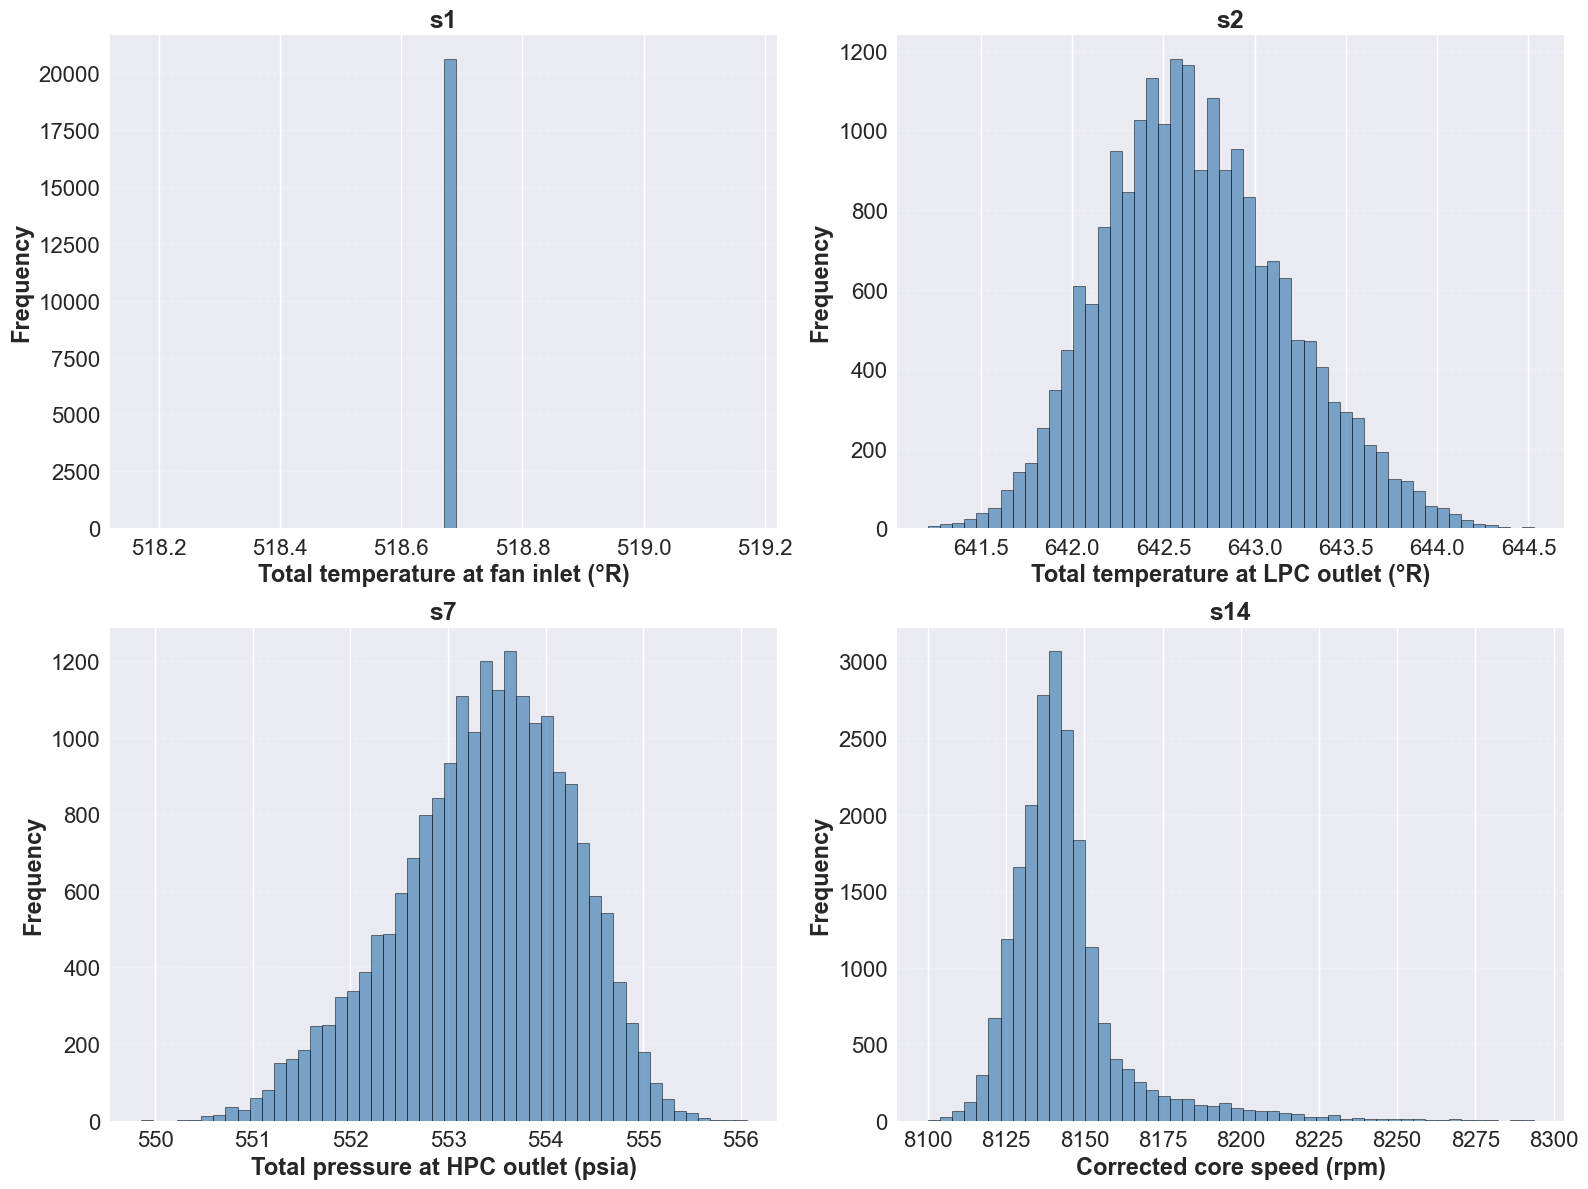

Representative sensor distribution plots complete

Generating distribution plots for all sensors...


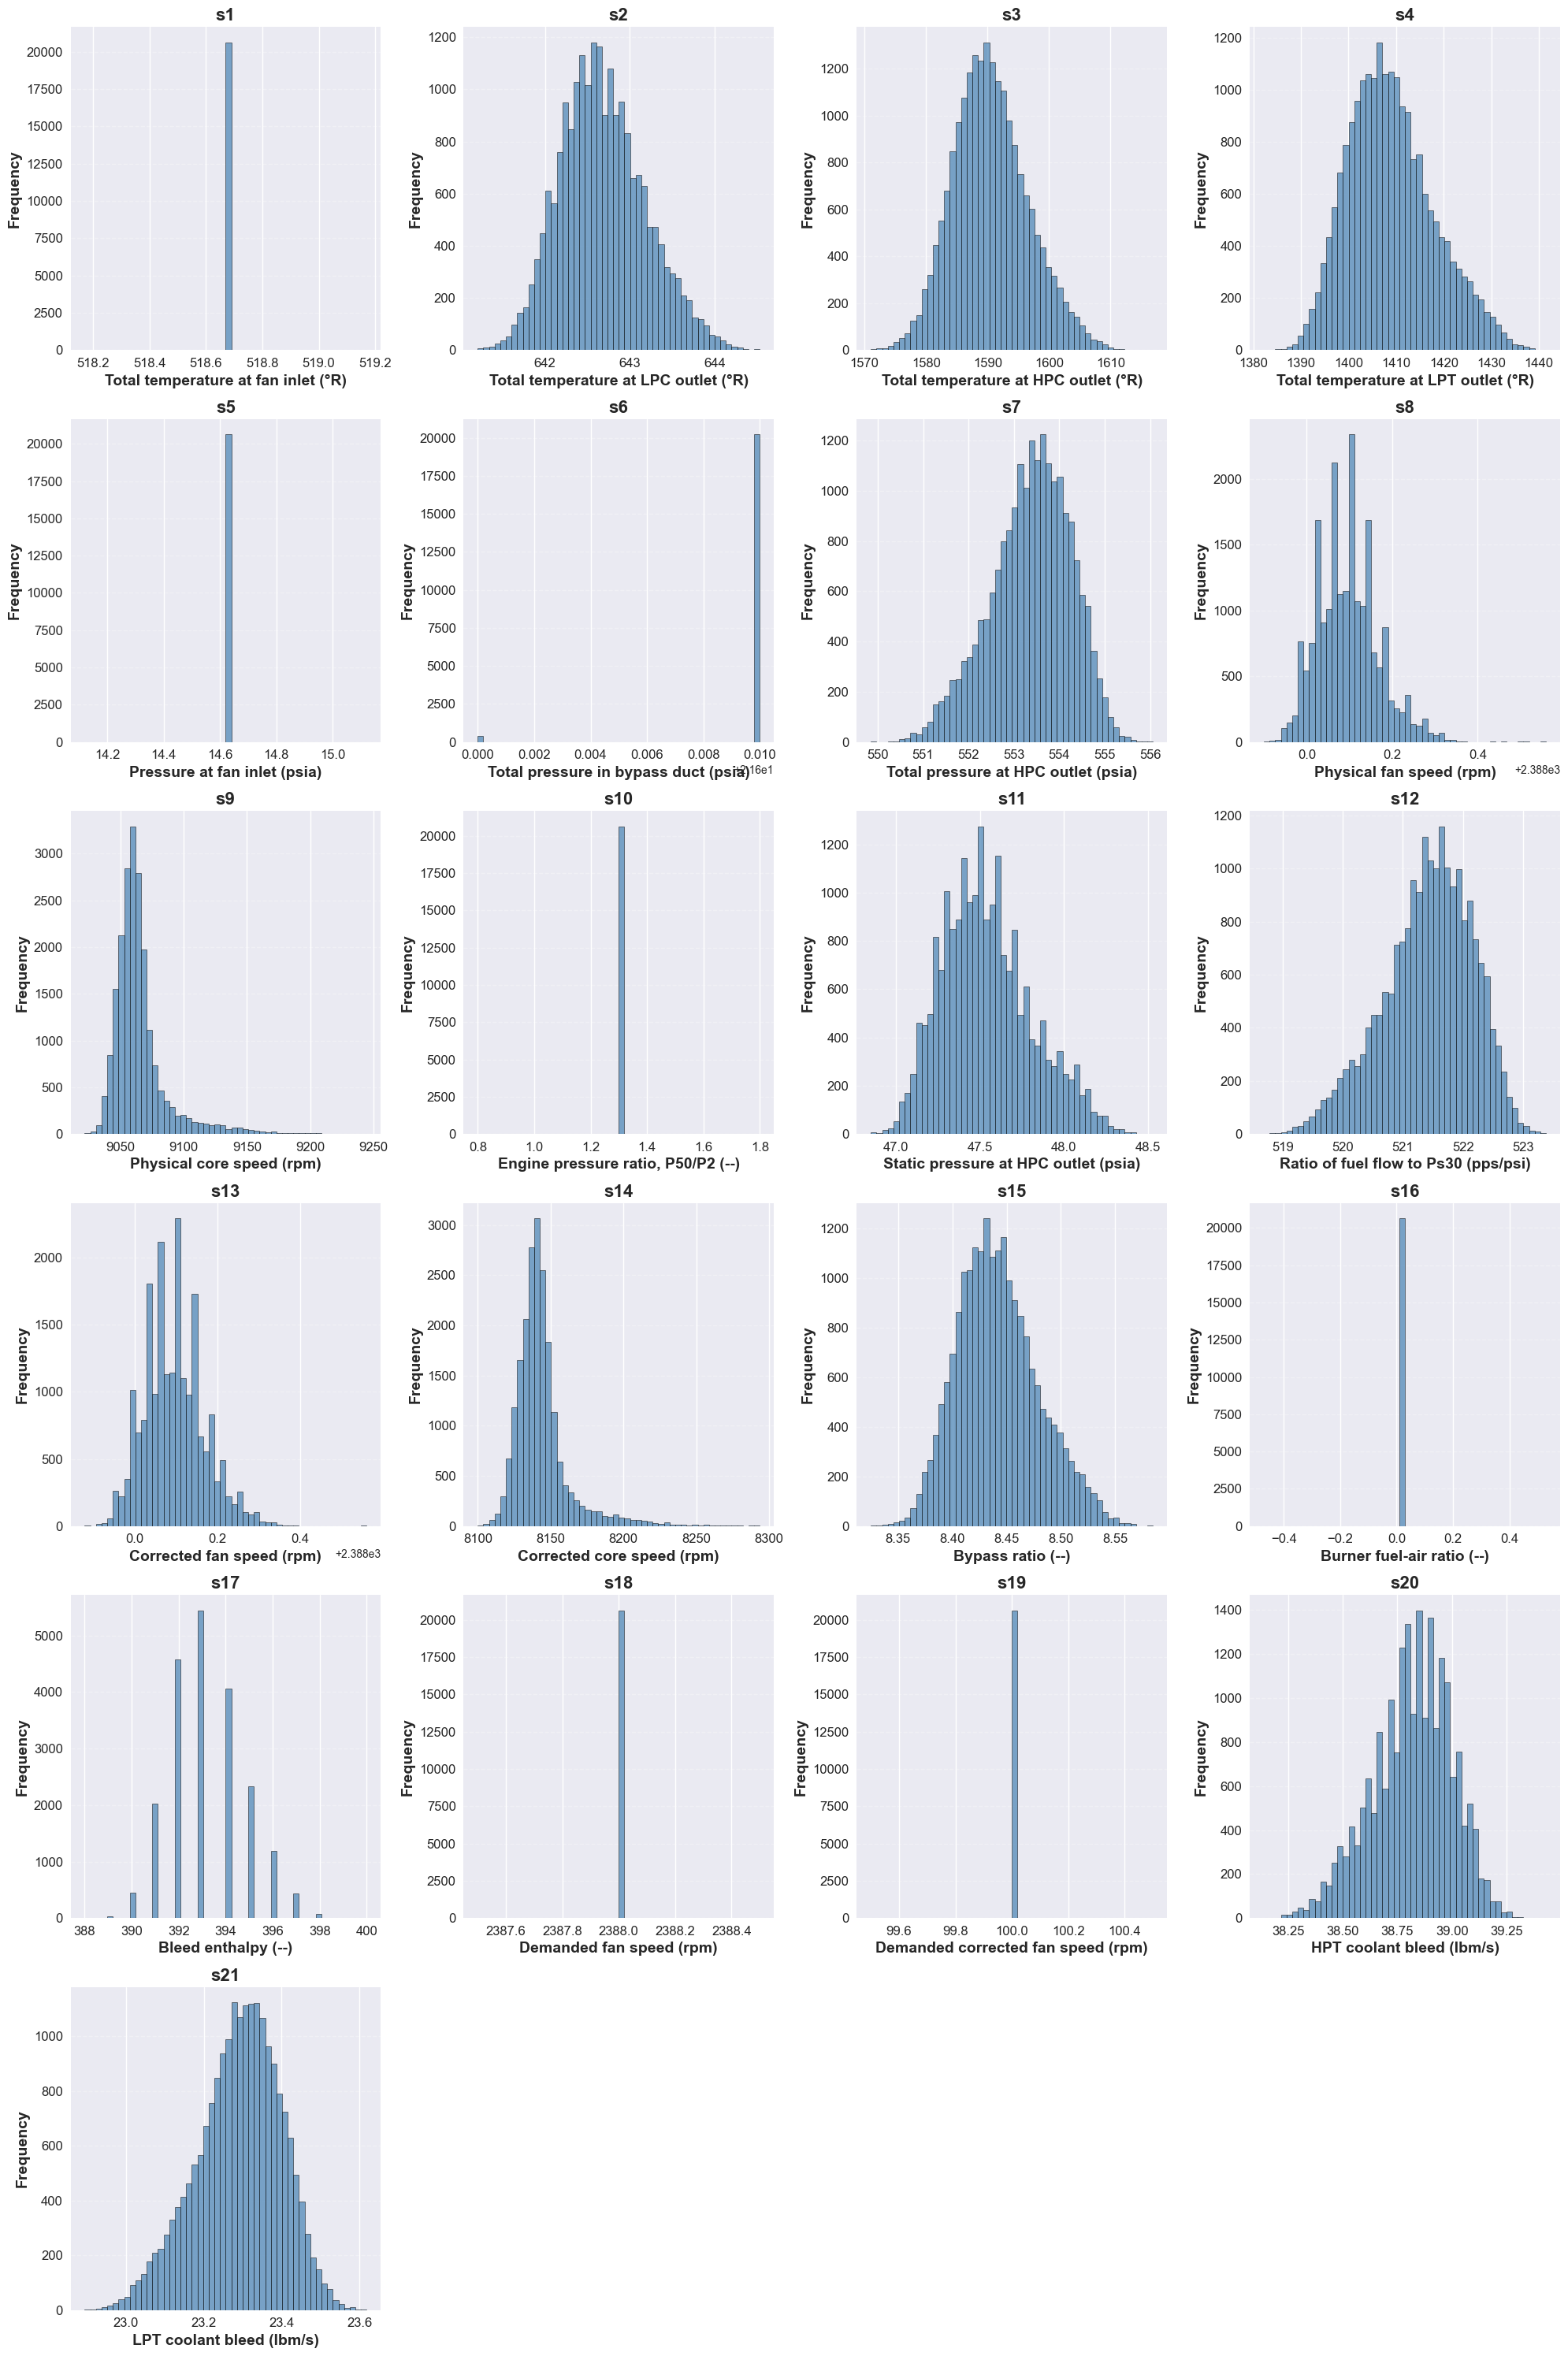

All sensor distribution plots complete


In [50]:
print("Correlation matrix heatmap complete")

# Plot distributions for representative sensors
print("\nGenerating distribution plots for representative sensors...")

representative_sensors = ['s1', 's2', 's7', 's14']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sensor in enumerate(representative_sensors):
    ax = axes[idx]
    
    # Create histogram
    ax.hist(raw_train_fd001[sensor], bins=50, color='steelblue', alpha=0.7, 
            edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel(sensor_names[sensor], fontsize=17, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=17, fontweight='bold')
    ax.set_title(f'{sensor}', fontsize=18, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()

print("Representative sensor distribution plots complete")

# Plot distributions for all sensors
print("\nGenerating distribution plots for all sensors...")

# Get all sensor columns
sensor_cols_all = [f's{i}' for i in range(1, 22)]

# Create subplots for all 21 sensors
n_sensors = len(sensor_cols_all)
n_cols = 4
n_rows = (n_sensors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_sensors > 1 else [axes]

for idx, sensor in enumerate(sensor_cols_all):
    ax = axes[idx]
    
    # Create histogram
    ax.hist(raw_train_fd001[sensor], bins=50, color='steelblue', alpha=0.7, 
            edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel(sensor_names[sensor], fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax.set_title(f'{sensor}', fontsize=16, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='both', labelsize=12)

# Hide unused subplots
for idx in range(n_sensors, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("All sensor distribution plots complete")

In [51]:
# ============================================================================
# Standardization Code
# ============================================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Identifier columns 
FD001_identifiers = ['engine', 'cycle', 'RUL']
FD002_identifiers = ['engine', 'cycle', 'RUL']
FD003_identifiers = ['engine', 'cycle', 'RUL']
FD004_identifiers = ['engine', 'cycle', 'RUL']

# Function to standardize datasets
def standardize_dataset_train(df, identifier_columns):
    features = df.drop(columns=identifier_columns, errors='ignore')
    identifiers = df[identifier_columns]
    
    scaler = StandardScaler()
    features_standardized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    
    return identifiers.reset_index(drop=True), features_standardized, scaler

def standardize_dataset_test(df, identifier_columns, scaler):
    features = df.drop(columns=identifier_columns, errors='ignore')
    identifiers = df[identifier_columns]
    
    features_standardized = pd.DataFrame(scaler.transform(features), columns=features.columns)
    
    return pd.concat([identifiers.reset_index(drop=True), features_standardized.reset_index(drop=True)], axis=1)


# Standardize training datasets
FD001_identifiers_train, FD001_train_features_standardized, FD001_scaler = standardize_dataset_train(raw_train_fd001, FD001_identifiers)
#FD002_identifiers_train, FD002_train_features_standardized, FD002_scaler = standardize_dataset_train(raw_train_fd002, FD002_identifiers)
#FD003_identifiers_train, FD003_train_features_standardized, FD003_scaler = standardize_dataset_train(raw_train_fd003, FD003_identifiers)


# Standardize testing datasets using the scalers fitted on training data
FD001_test_standardized = standardize_dataset_test(raw_test_fd001, FD001_identifiers, FD001_scaler)
#FD002_test_standardized = standardize_dataset_test(raw_test_fd002, FD002_identifiers, FD002_scaler)
#FD003_test_standardized = standardize_dataset_test(raw_test_fd003, FD003_identifiers, FD003_scaler)

# Combine back identifiers and standardized features for training datasets
FD001_train_standardized = pd.concat([FD001_identifiers_train, FD001_train_features_standardized], axis=1)
#FD002_train_standardized = pd.concat([FD002_identifiers_train, FD002_train_features_standardized], axis=1)
#FD003_train_standardized = pd.concat([FD003_identifiers_train, FD003_train_features_standardized], axis=1)


FD001_train = FD001_train_standardized
#FD002_train = FD002_train_standardized
#FD003_train = FD003_train_standardized

FD001_test = FD001_test_standardized
#FD002_test = FD002_test_standardized
#FD003_test = FD003_test_standardized


In [53]:
FD001_train.head(2)

engine  cycle  RUL       os1       os2  os3   s1        s2        s3  \
0       1      1  125 -0.315980 -1.372953  0.0  0.0 -1.721725 -0.134255   
1       1      2  125  0.872722 -1.031720  0.0  0.0 -1.061780  0.211528   

         s4  ...       s12       s13       s14       s15           s16  \
0 -0.925936  ...  0.334262 -1.058890 -0.269071 -0.603816 -1.387779e-17   
1 -0.643726  ...  1.174899 -0.363646 -0.642845 -0.275852 -1.387779e-17   

       s17  s18  s19       s20       s21  
0 -0.78171  0.0  0.0  1.348493  1.194427  
1 -0.78171  0.0  0.0  1.016528  1.236922  

[2 rows x 27 columns]

In [56]:
# ============================================================================
# Data Splitting Code (for reference - typically done after standardization)
# ============================================================================

from sklearn.model_selection import train_test_split

def separate_features_and_ids(df, id_cols):
    """
    Splits a dataframe into:
      - features (all sensor columns)
      - ids      (engine, cycle, RUL)
    """
    features = df.drop(columns=id_cols, errors='ignore')
    ids      = df[id_cols]
    return features, ids


def split_dataset(df_train, df_test):
    """
    Takes an FD00X training and test dataframe and returns:

        features_train, ids_train
        features_val,   ids_val
        features_test,  ids_test

    Train/val is split by ENGINE, so entire engine sequences
    stay together in either train or validation.
    """

    # Extract feature matrices + identifier columns
    train_features, train_ids = separate_features_and_ids(df_train, ['engine', 'cycle', 'RUL'])
    test_features,  test_ids  = separate_features_and_ids(df_test,  ['engine', 'cycle', 'RUL'])

    # Train/val split at ENGINE level
    engines = train_ids['engine'].unique()
    eng_train, eng_val = train_test_split(engines, test_size=0.2, random_state=42)

    # Build train split
    features_train = train_features[train_ids['engine'].isin(eng_train)]
    ids_train      = train_ids[     train_ids['engine'].isin(eng_train)]

    # Build validation split
    features_val   = train_features[train_ids['engine'].isin(eng_val)]
    ids_val        = train_ids[     train_ids['engine'].isin(eng_val)]

    # Test set is already separate
    return (
        features_train, ids_train,
        features_val,   ids_val,
        test_features,  test_ids
    )

In [57]:
# ------------------------------------------------------------
# Can Apply the same logic to FD001–FD003
# ------------------------------------------------------------

(
     fd001_feats_train,
     fd001_ids_train,
     fd001_feats_val,
     fd001_ids_val,
     fd001_feats_test,
     fd001_ids_test,
 ) = split_dataset(FD001_train, FD001_test)

In [59]:
FD001_train.head(1)

engine  cycle  RUL      os1       os2  os3   s1        s2        s3  \
0       1      1  125 -0.31598 -1.372953  0.0  0.0 -1.721725 -0.134255   

         s4  ...       s12      s13       s14       s15           s16  \
0 -0.925936  ...  0.334262 -1.05889 -0.269071 -0.603816 -1.387779e-17   

       s17  s18  s19       s20       s21  
0 -0.78171  0.0  0.0  1.348493  1.194427  

[1 rows x 27 columns]

In [ ]:
import numpy as np
import pandas as pd

def create_sliding_windows(df, window_size,
                           id_col="engine",
                           time_col="cycle",
                           target_col="RUL"):
    """
    Turn a sequence dataframe into sliding windows.

        X: all sensor features over the window
        y: RUL at the last time step of the window
        ids: engine + start/end cycle + RUL for that window
    """

    # Use all columns except engine, time, and target as features
    feature_cols = [
        c for c in df.columns
        if c not in [id_col, time_col, target_col]
    ]

    X = []
    y = []
    ids_rows = []

    # Process each engine separately to prevant data leakage
    for _, seq_df in df.groupby(id_col):
        # Sort by time
        seq_df = seq_df.sort_values(time_col).reset_index(drop=True)

        # Sliding window over time implementeation
        for i in range(len(seq_df) - window_size + 1):
            window = seq_df.iloc[i : i + window_size]

            X.append(window[feature_cols].values)
            y.append(window[target_col].iloc[-1])

            ids_rows.append({
                id_col:              window[id_col].iloc[-1],
                f"start_{time_col}": window[time_col].iloc[0],
                f"end_{time_col}":   window[time_col].iloc[-1],
                target_col:          window[target_col].iloc[-1],
            })

    X   = np.array(X)          # shape: (n_windows, window_size, n_features)
    y   = np.array(y)          # shape: (n_windows,)
    ids = pd.DataFrame(ids_rows)

    return X, y, ids


# ============================================================
# FD001 windowed splits (reuse same engine split as non-window)
# ============================================================

# Engines in train/val according to the earlier split_dataset() result
fd001_train_engines = fd001_ids_train["engine"].unique()
fd001_val_engines   = fd001_ids_val["engine"].unique()

fd001_train_df = FD001_train[FD001_train["engine"].isin(fd001_train_engines)].copy()
fd001_val_df   = FD001_train[FD001_train["engine"].isin(fd001_val_engines)].copy()
fd001_test_df  = FD001_test.copy()

FD001_X_train_windowed, FD001_y_train_windowed, FD001_ids_train_windowed = \
    create_sliding_windows(fd001_train_df, WINDOW_SIZE)

FD001_X_val_windowed,   FD001_y_val_windowed,   FD001_ids_val_windowed   = \
    create_sliding_windows(fd001_val_df,   WINDOW_SIZE)

FD001_X_test_windowed,  FD001_y_test_windowed,  FD001_ids_test_windowed  = \
    create_sliding_windows(fd001_test_df,  WINDOW_SIZE)

"""
# ============================================================
# FD002
# ============================================================

fd002_train_engines = fd002_ids_train["engine"].unique()
fd002_val_engines   = fd002_ids_val["engine"].unique()

fd002_train_df = FD002_train[FD002_train["engine"].isin(fd002_train_engines)].copy()
fd002_val_df   = FD002_train[FD002_train["engine"].isin(fd002_val_engines)].copy()
fd002_test_df  = FD002_test.copy()

FD002_X_train_windowed, FD002_y_train_windowed, FD002_ids_train_windowed = \
    create_sliding_windows(fd002_train_df, WINDOW_SIZE)

FD002_X_val_windowed,   FD002_y_val_windowed,   FD002_ids_val_windowed   = \
    create_sliding_windows(fd002_val_df,   WINDOW_SIZE)

FD002_X_test_windowed,  FD002_y_test_windowed,  FD002_ids_test_windowed  = \
    create_sliding_windows(fd002_test_df,  WINDOW_SIZE)


# ============================================================
# FD003
# ============================================================

fd003_train_engines = fd003_ids_train["engine"].unique()
fd003_val_engines   = fd003_ids_val["engine"].unique()

fd003_train_df = FD003_train[FD003_train["engine"].isin(fd003_train_engines)].copy()
fd003_val_df   = FD003_train[FD003_train["engine"].isin(fd003_val_engines)].copy()
fd003_test_df  = FD003_test.copy()

FD003_X_train_windowed, FD003_y_train_windowed, FD003_ids_train_windowed = \
    create_sliding_windows(fd003_train_df, WINDOW_SIZE)

FD003_X_val_windowed,   FD003_y_val_windowed,   FD003_ids_val_windowed   = \
    create_sliding_windows(fd003_val_df,   WINDOW_SIZE)

FD003_X_test_windowed,  FD003_y_test_windowed,  FD003_ids_test_windowed  = \
    create_sliding_windows(fd003_test_df,  WINDOW_SIZE)

"""

'\n# ============================================================\n# FD002\n# ============================================================\n\nfd002_train_engines = fd002_ids_train["engine"].unique()\nfd002_val_engines   = fd002_ids_val["engine"].unique()\n\nfd002_train_df = FD002_train[FD002_train["engine"].isin(fd002_train_engines)].copy()\nfd002_val_df   = FD002_train[FD002_train["engine"].isin(fd002_val_engines)].copy()\nfd002_test_df  = FD002_test.copy()\n\nFD002_X_train_windowed, FD002_y_train_windowed, FD002_ids_train_windowed =     create_sliding_windows(fd002_train_df, WINDOW_SIZE)\n\nFD002_X_val_windowed,   FD002_y_val_windowed,   FD002_ids_val_windowed   =     create_sliding_windows(fd002_val_df,   WINDOW_SIZE)\n\nFD002_X_test_windowed,  FD002_y_test_windowed,  FD002_ids_test_windowed  =     create_sliding_windows(fd002_test_df,  WINDOW_SIZE)\n\n\n# ============================================================\n# FD003\n# =======================================================